In [1]:
# Standard libraries
import numpy as np
import scipy as sp
import multiprocessing as mp
from scipy import signal

from tqdm.notebook import tqdm
from multiprocessing import pool
from multiprocessing import freeze_support

import matplotlib as mpl
import matplotlib.pyplot as plt
cmap = plt.get_cmap("tab10")
cmap2 = plt.get_cmap("tab20")

In [2]:
# Special libraries
import qutip as qt
import sys

sys.path.append(r'E:\Quntum Technology\DMD for Quantum\Mygit\dmdlab')
                
# https://pypi.org/pip install dmdlabproject/dmdlab/
import dmdlab as dmd

In [3]:
import importlib
hf = importlib.import_module('helper_functions')

# Bilinear Dynamic Mode Decomposition for Quantum Control

https://arxiv.org/abs/2010.14577

Data-driven methods for establishing quantum optimal control (QOC) using time-dependent control pulses tailored to specific quantum dynamical systems and desired control objectives are critical for many emerging quantum technologies. We develop a data-driven regression procedure, bilinear dynamic mode decomposition (biDMD), that leverages time-series measurements to establish quantum system identification for QOC. The biDMD optimization framework is a physics-informed regression that makes use of the known underlying Hamiltonian structure. Further, the biDMD can be modified to model both fast and slow sampling of control signals, the latter by way of stroboscopic sampling strategies. The biDMD method provides a flexible, interpretable, and adaptive regression framework for real-time, online implementation in quantum systems. Further, the method has strong theoretical connections to Koopman theory, which approximates non-linear dynamics with linear operators. In comparison with many machine learning paradigms, it requires minimal data and the biDMD model is easily updated as new data is collected. We demonstrate the efficacy and performance of the approach on a number of representative quantum systems, showing that it also matches experimental results.

Andy Goldschmidt, Eurika Kaiser, Jonathan L. Dubois, Steven L. Brunton, J. Nathan Kutz

## Data storage

First we define a utilty class for storing experiment data.

In [4]:
class QubitExperiment:
    ''' A container for data saved during a set of experiments. '''
    def __init__(self):
        self.X = []
        self.Y = []
        self.Uy = []
        self.Ty = []
        self.Args_List = []
        self._finalized = False
        
    def save(self, iX, iY, iUy, iTy, iArgs):
        if self._finalized:
            raise ValueError('Cannot save data. QubitExperiment has been finalized.')
            
        self.X.append(iX)
        self.Y.append(iY)
        self.Uy.append(iUy)
        self.Ty.append(iTy)
        self.Args_List.append(iArgs)
        
    def dump(self):
        if self._finalized:
            raise ValueError('Cannot dump data. QubitExperiment has been finalized.')
        
        for i in range(len(self.X)):
            yield self.X[i], self.Y[i], self.Uy[i], self.Ty[i], self.Args_List[i]

    def finalize(self):
        self._finalized = True
        self.X_flat = np.hstack(self.X)
        self.Y1_flat = np.hstack([y[:, :-1] for y in self.Y])
        self.Y2_flat = np.hstack([y[:, 1:] for y in self.Y])
        self.U1y_flat = np.hstack([u[:, :-1] for u in self.Uy])
        self.T1y_flat = np.hstack([t[:-1] for t in self.Ty])


def join_qubit_experiments(qbExpermList):
    joinedQbExperm = QubitExperiment()
    for aQbExperm in qbExpermList:
        for data in aQbExperm.dump():
            joinedQbExperm.save(*data)
    joinedQbExperm.finalize()
    return joinedQbExperm

# Example 1

We start with the system described by the Hamiltonian,
\begin{equation}
    H(t) = \pi \sigma_3 + V_0 \cos(\Omega t) \sigma_1
\end{equation}

This description gives us time units that are in terms of the bare oscillation. In these units, can make a physical estimate of $V_0$. To do this, we make some assumptions on our experiment. Suppose that our qubit has a resonance frequency of 4.1 GHz. Further, let's say that a Pi pulse (the control signal that maps $\sigma_z=0$ to $\sigma_z=1$, or 1/4 of the period of a Rabi oscillation) takes 86ns when the input drive amplitude is 100mV. So far these numbers imply $V_0\approx 0.004$. If we have a maximum drive amplitude of 500 mV, our coupling can be increased by a factor of 5 to $V_0 \approx 0.02$. Finally, suppose we have a sample rate around 32 Ghz. That means we can sample approximately 8 times in one period of the bare frequency.

The experiment we will run below won't really match these values. We increase the coupling strength to $V_0 = 1$ because we want to apply a pulse that is off resonance and get some action in $\sigma_z$ in not too many timesteps. If we want to use physical values, we could decrease the amount we are off of resonace and increase the timesteps to accommodate but this is perhaps less  useful visually.

We will run multiple experiments to make sure that our model doesn't overfit a single training pulse. You don't need many experiments for take care of this. 

This first block of code sets a lot of the experimental parameters we can adjust.

In [5]:
# Qubit frequency
w0 = 1 
Delta = 2*np.pi*w0

# Time series parameters
# -- Pick a simulation discretization and a measurement discretization (measured per bare oscillation)
# -- Make sure your discretizations divide each other...
sim_discretization = 32
m_discretization = 16
sim_dt =  2*np.pi/Delta/sim_discretization
dt = 2*np.pi/Delta/m_discretization
t0 = 0
tf = 5
ts = np.linspace(t0, tf,  int((tf-t0)//sim_dt), endpoint=True)
ts_test = np.linspace(t0, 5*tf, int((5*tf-t0)//sim_dt), endpoint=True)

# Hamiltonian
# -- Lab frame (Linear Polarization)
H0_lab = Delta/2*qt.sigmaz()
V0 = 1
fc_lab = lambda t, args: args['u'](t)*np.cos(args['Omega']*t)
H_lab = [H0_lab, [qt.sigmax(), fc_lab]]

# Dissipation
dissipation = [[.04*qt.sigmax()], [.1*qt.sigmam()]]

# Choose measurements and initial state
measure_list = [qt.sigmax(), qt.sigmay(), qt.sigmaz()] 
measure_name = ['<{}>'.format(s) for s in ['x','y','z']]
n_measure = len(measure_list)
psi0 = qt.basis(2,1)

# Set measurement certainty
N_measure = 1e4
sigma = 1/np.sqrt(N_measure)

In [6]:
true_eigs = np.exp((.04 + 2j*np.pi) * dt)
print(true_eigs)

(0.9261921208735449+0.3836413378289233j)


In [7]:
# In a new cell in your Examples.ipynb notebook

import numpy as np
import qutip as qt

# --- 1. Define the System (from your previous cell) ---
w0 = 1 
Delta = 2 * np.pi * w0
H0_lab = Delta / 2 * qt.sigmaz()
dissipation = [np.sqrt(0.04) * qt.sigmax(), np.sqrt(0.1) * qt.sigmam()] # Rates are sqrt() in QuTiP

# --- 2. Construct the Full Liouvillian Operator ---
# QuTiP's liouvillian function combines the Hamiltonian (drift) and 
# the collapse operators (dissipation) into a single super-operator L.
L = qt.liouvillian(H0_lab, c_ops=dissipation)

# --- 3. Calculate the Eigenvalues of the Liouvillian ---
# The eigenvalues of L are the continuous-time poles of the system.
# They are often called "eigenenergies" in QuTiP.
continuous_poles = L.eigenenergies()

# --- 4. Identify the Ground Truth Poles of Interest ---
# The Liouvillian has many poles. We are interested in the ones that 
# describe the primary oscillation and decay. These are the non-zero
# eigenvalues with the smallest magnitude real part (slowest decay).

# Sort the poles by the magnitude of their real part (from smallest to largest decay)
# We ignore purely zero eigenvalues which represent the steady state.
sorted_poles = sorted(
    [p for p in continuous_poles if np.abs(p) > 1e-8], 
    key=lambda x: abs(np.real(x))
)

# The dominant oscillatory poles are the first two in this sorted list
# that have a significant imaginary part.
ground_truth_continuous_poles = None
for pole in sorted_poles:
    if abs(np.imag(pole)) > 1e-6:
        # Find the first one with an imaginary part and its conjugate
        ground_truth_continuous_poles = np.array([pole, np.conj(pole)])
        break
        
print("--- Ground Truth Calculation ---")
print("Full Liouvillian Operator Constructed.")
print(f"Identified dominant continuous-time poles: {ground_truth_continuous_poles[0]:.4f} and {ground_truth_continuous_poles[1]:.4f}")

# --- 5. Map to Discrete Time for Comparison ---
# Use the 'dt' from your experiment setup
sim_discretization = 32
m_discretization = 16
dt = 2*np.pi/Delta/m_discretization

true_eigs = np.exp(ground_truth_continuous_poles * dt)

print(f"\nResulting discrete-time eigenvalues for DMD comparison:")
print(true_eigs)

--- Ground Truth Calculation ---
Full Liouvillian Operator Constructed.
Identified dominant continuous-time poles: -0.0900-6.2831j and -0.0900+6.2831j

Resulting discrete-time eigenvalues for DMD comparison:
[0.91870033-0.38052957j 0.91870033+0.38052957j]


We run experiments for a random assortment of frequencies that we think might be in the ballpark of the resonance frequency.

In [8]:
np.random.seed(1)

# Run experiments at some off-resonance frequencies and miss resonance by at least +/- 0.05
n_experiments = 10
frequency_list = np.hstack([np.random.rand(n_experiments//2)*.1+.85, 
                            np.random.rand(n_experiments - n_experiments//2)*.1+1.05])
print(frequency_list)
QbData = QubitExperiment()
for w1 in frequency_list:
    # Simulate the training dynamics
    c_args = {'Omega': 2*np.pi*w1, 'u': lambda t: V0*np.ones_like(t)}
    res = qt.mesolve(H_lab, psi0, ts, dissipation, measure_list, args=c_args)

    # Measure only between some skipped points
    skip = sim_discretization//m_discretization
    X = np.array(res.expect)
    Y = X[:,::skip]
    Ty = ts[::skip]
    Uy = fc_lab(Ty, c_args).reshape(1,-1)

    # Add noise to everything but the prepared state
    Y[:,1:] += np.random.randn(*Y[:,1:].shape)*sigma

    # Save the experiment data
    QbData.save(X, Y, Uy, Ty, c_args)

# Finish running experiments
QbData.finalize()

[0.8917022  0.92203245 0.85001144 0.88023326 0.86467559 1.05923386
 1.06862602 1.08455607 1.08967675 1.10388167]


c:\ProgramData\anaconda3\envs\QuantumD\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


We fit the bilinear DMD model and back out a resonance frequency from the observed eigenvalues.

Estimated bare frequency: 1.0097227635231378
Eigs:  [0.91588884+0.38347705j 0.91588884-0.38347705j 0.98933368+0.j        ]


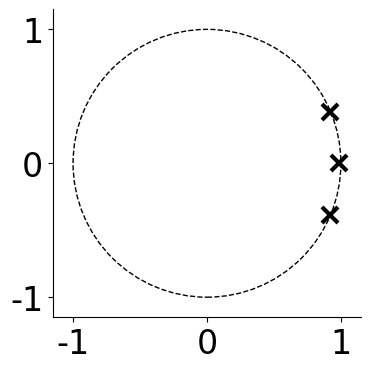

In [9]:
# Fit the model
model = dmd.biDMD(QbData.Y2_flat, QbData.Y1_flat, QbData.U1y_flat, QbData.T1y_flat, threshold_type='count', threshold=6)

# Estimate the bare frequency
est_bare = np.abs(np.angle(model.eigs[1])/dt/2/np.pi)

# Plot the eigenvvalues
fig, ax = plt.subplots(1,figsize=[4,4])
ax.set_aspect('equal'), ax.set_xlim([-1.15, 1.15]), ax.set_ylim([-1.15, 1.15])
ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])
ax.set_xticklabels([-1,0,1],fontsize=24)
ax.set_yticklabels([-1,0,1],fontsize=24)
for eigs in model.eigs:
    ax.plot(eigs.real, eigs.imag, ms=12, marker='x', markeredgewidth=3, ls='', color='k')
ax.add_artist(plt.Circle((0, 0), 1, color='k', linestyle='--', fill=False))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Estimated bare frequency:', est_bare)
print('Eigs: ', model.eigs)

Estimated bare frequency: 1.00971817126717
Eigs:  [0.91588299+0.38347266j 0.91588299-0.38347266j 0.98933125+0.j        ]


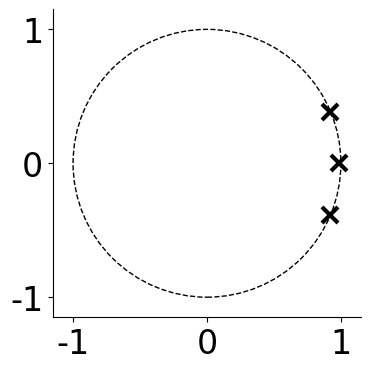

In [10]:
# Fit the model
model1 = dmd.ibiDMD(QbData.Y2_flat, QbData.Y1_flat, QbData.U1y_flat, QbData.T1y_flat, threshold_type='count', threshold=6, forgetting_factor =.9999)

# Estimate the bare frequency
est_bare = np.abs(np.angle(model1.eigs[1])/dt/2/np.pi)

# Plot the eigenvvalues
fig, ax = plt.subplots(1,figsize=[4,4])
ax.set_aspect('equal'), ax.set_xlim([-1.15, 1.15]), ax.set_ylim([-1.15, 1.15])
ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])
ax.set_xticklabels([-1,0,1],fontsize=24)
ax.set_yticklabels([-1,0,1],fontsize=24)
for eigs in model1.eigs:
    ax.plot(eigs.real, eigs.imag, ms=12, marker='x', markeredgewidth=3, ls='', color='k')
ax.add_artist(plt.Circle((0, 0), 1, color='k', linestyle='--', fill=False))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Estimated bare frequency:', est_bare)
print('Eigs: ', model1.eigs)

Starting Bayesian Incremental Fit. Total Snapshots: 790
Bayesian fit complete.
Estimated bare frequency: 1.0033731148010923
Eigs:  [0.98934122+0.j         0.91581752+0.38343065j 0.91581752-0.38343065j]


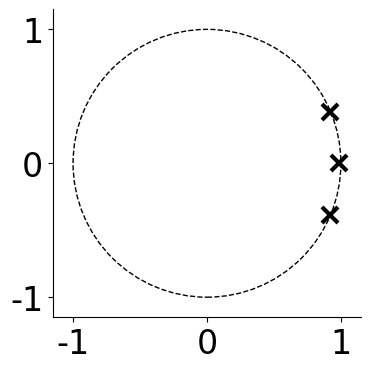

In [11]:
# Fit the model
dt = QbData.T1y_flat[1] - QbData.T1y_flat[0]

# 2. Initialize the Bayesian_biDMD model
#    It takes the same data arguments as biDMD
rr = 3
model_bayes = dmd.Bayesian_biDMD(
    QbData.Y2_flat, 
    QbData.Y1_flat, 
    QbData.U1y_flat,
    QbData.T1y_flat,
    rank=rr,
    forgetting_factor=0.999
)
model_bayes.rank = rr
# 3. Fit the model (the method is now overridden)
model_bayes.fit()

# Estimate the bare frequency
est_bare = np.abs(np.angle(model_bayes.eigs[1])/dt/2/np.pi)

# Plot the eigenvvalues
fig, ax = plt.subplots(1,figsize=[4,4])
ax.set_aspect('equal'), ax.set_xlim([-1.15, 1.15]), ax.set_ylim([-1.15, 1.15])
ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])
ax.set_xticklabels([-1,0,1],fontsize=24)
ax.set_yticklabels([-1,0,1],fontsize=24)
for eigs in model_bayes.eigs:
    ax.plot(eigs.real, eigs.imag, ms=12, marker='x', markeredgewidth=3, ls='', color='k')
ax.add_artist(plt.Circle((0, 0), 1, color='k', linestyle='--', fill=False))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Estimated bare frequency:', est_bare)
print('Eigs: ', model_bayes.eigs)

Starting Bayesian Incremental Fit. Total Snapshots: 790
Bayesian fit complete.

--- Bayesian Model Results ---
Final posterior mean eigenvalues:
[0.98934122+0.j         0.91581752+0.38343065j 0.91581752-0.38343065j]
Estimated Bare Frequency (Bayesian Mean): 1.0034 GHz

Drawing 200 samples from the posterior to visualize uncertainty...


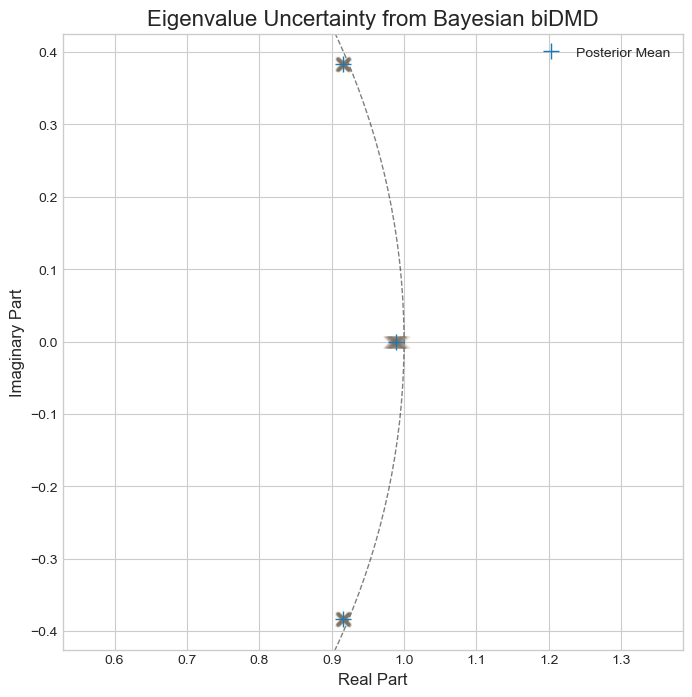

In [12]:



# Define time step for frequency calculation
dt = QbData.T1y_flat[1] - QbData.T1y_flat[0]

# 2. Initialize the Bayesian_biDMD model
#    It takes the same data arguments as biDMD
rr = 3
model_bayes = dmd.Bayesian_biDMD(
    QbData.Y2_flat, 
    QbData.Y1_flat, 
    QbData.U1y_flat,
    QbData.T1y_flat,
    rank=rr,
    forgetting_factor=0.999
)
model_bayes.rank = rr
# 3. Fit the model (the method is now overridden)
model_bayes.fit()

# 4. Analyze the results
print("\n--- Bayesian Model Results ---")
# The final "best estimate" eigenvalues are stored in model_bayes.eigs
print("Final posterior mean eigenvalues:")
print(model_bayes.eigs)

# Estimate the bare frequency from the posterior mean
est_bare_bayes = np.abs(np.angle(model_bayes.eigs[1]) / dt / (2 * np.pi))
print(f"Estimated Bare Frequency (Bayesian Mean): {est_bare_bayes:.4f} GHz")

# 5. Visualize the uncertainty (the key advantage)
print("\nDrawing 200 samples from the posterior to visualize uncertainty...")
g_samples = model_bayes.sample_posterior_G(n_samples=200)

sampled_eigs = []
state_dim = QbData.Y1_flat.shape[0]
U_r, _, _ = np.linalg.svd(QbData.Y1_flat, full_matrices=False)
U_r = U_r[:, :rr]

for g_sample in g_samples:
    A_sample = g_sample[:, :state_dim]
    A_reduced_sample = U_r.T @ A_sample @ U_r
    eigvals, _ = np.linalg.eig(A_reduced_sample)
    sampled_eigs.append(eigvals)

# Create the uncertainty plot
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 8))
# Plot all sampled eigenvalues as transparent dots
for eigs in sampled_eigs:
    plt.plot(np.real(eigs), np.imag(eigs), 'x', markersize=8, alpha=0.05)

# Plot the mean eigenvalues in red
plt.plot(np.real(model_bayes.eigs), np.imag(model_bayes.eigs), '+', markersize=12, label='Posterior Mean')
plt.title("Eigenvalue Uncertainty from Bayesian biDMD", fontsize=16)
plt.xlabel("Real Part", fontsize=12)
plt.ylabel("Imaginary Part", fontsize=12)
unit_circle = plt.Circle((0,0), 1, color='k', fill=False, linestyle='--', alpha=0.5)
plt.gca().add_artist(unit_circle)
plt.axis('equal')
plt.legend()
plt.show()

Fitting standard ibiDMD model...
Final reconstruction error (ibiDMD, manual): 7.69e-01

Fitting Bayesian_biDMD model...
Starting Bayesian Incremental Fit. Total Snapshots: 790
Bayesian fit complete.
Final reconstruction error (Bayesian Mean): 7.69e-01


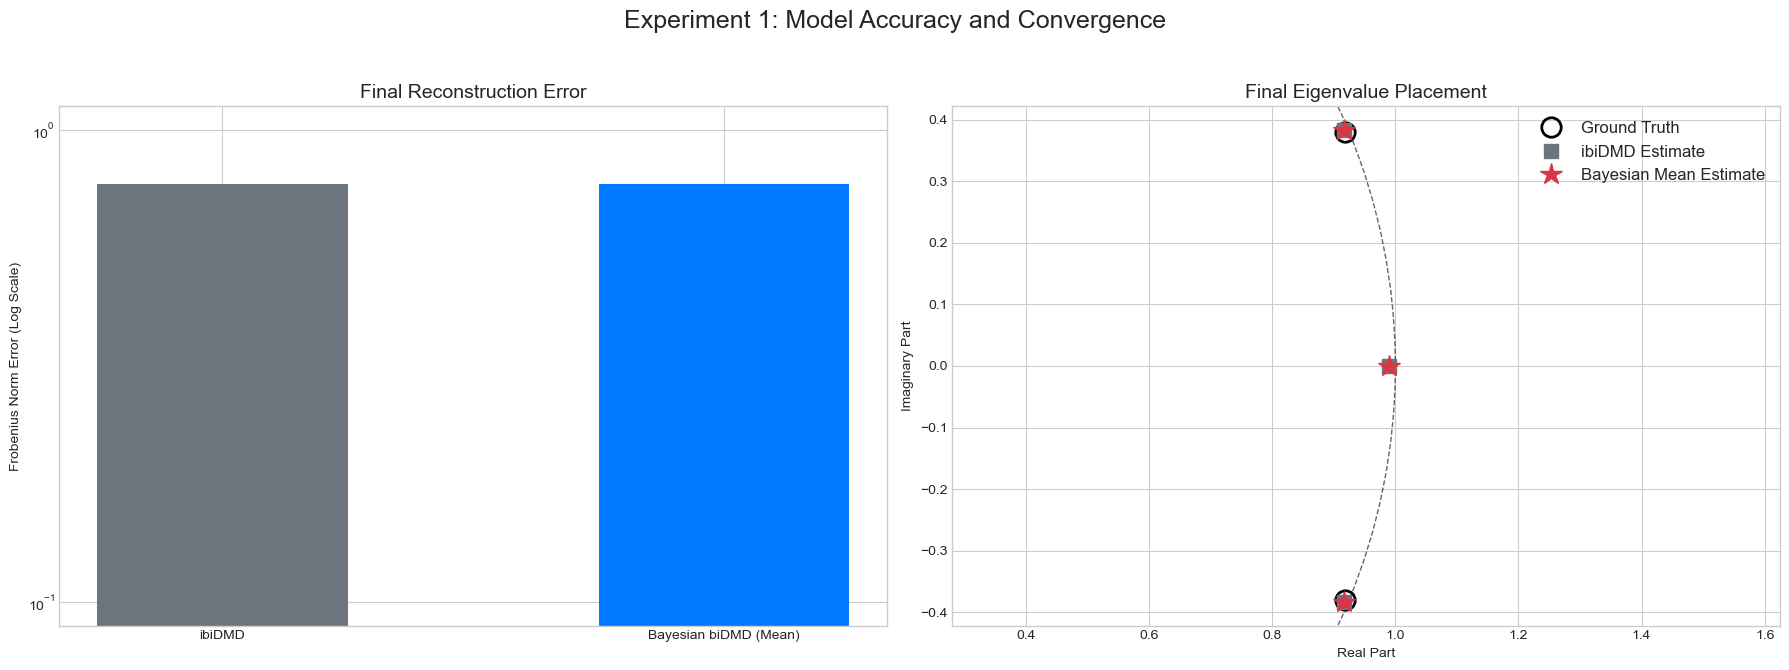

In [13]:

dt = QbData.T1y_flat[1] - QbData.T1y_flat[0]
rank = 6 

# --- 2. Fit the standard ibiDMD model ---
print("Fitting standard ibiDMD model...")
model_ibiDMD = dmd.ibiDMD(
    QbData.Y2_flat, 
    QbData.Y1_flat, 
    QbData.U1y_flat,
    QbData.T1y_flat,
    threshold_type='count', 
    threshold=rank
)

# --- CORRECTED: Manually calculate reconstruction error for ibiDMD ---
X_prime_reconstructed = model_ibiDMD.A @ QbData.Y1_flat + model_ibiDMD.B @ (QbData.U1y_flat * QbData.Y1_flat)
error_ibiDMD = np.linalg.norm(QbData.Y2_flat - X_prime_reconstructed, 'fro')
print(f"Final reconstruction error (ibiDMD, manual): {error_ibiDMD:.2e}")


# --- 3. Fit the Bayesian_biDMD model ---
print("\nFitting Bayesian_biDMD model...")
model_bayes = dmd.Bayesian_biDMD(
    QbData.Y2_flat, 
    QbData.Y1_flat, 
    QbData.U1y_flat,
    QbData.T1y_flat,
    rank=rank,
    forgetting_factor=1.0  
)
model_bayes.rank = rank
model_bayes.fit()
# The Bayesian class inherits from biDMD -> DMD, so it has the method
error_bayes = model_bayes.reconstruction_error()
print(f"Final reconstruction error (Bayesian Mean): {error_bayes:.2e}")


# --- 4. Plotting the Results ---
# This section remains the same as it correctly uses the output attributes.
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Experiment 1: Model Accuracy and Convergence', fontsize=18)

# Plot 1: Reconstruction Error Comparison
ax1.bar(['ibiDMD', 'Bayesian biDMD (Mean)'], [error_ibiDMD, error_bayes], 
        color=['#6c757d', '#007bff'], width=0.5)
ax1.set_yscale('log')
ax1.set_title('Final Reconstruction Error', fontsize=14)
ax1.set_ylabel('Frobenius Norm Error (Log Scale)')
ax1.tick_params(axis='y', which='both', labelleft=True)

# Plot 2: Eigenvalue Comparison


ax2.plot(np.real(true_eigs), np.imag(true_eigs), 'o', markerfacecolor='none', 
         markeredgecolor='black', markersize=14, markeredgewidth=2, label='Ground Truth')
ax2.plot(np.real(model_ibiDMD.eigs), np.imag(model_ibiDMD.eigs), 's', color='#6c757d', 
         markersize=10, label='ibiDMD Estimate')
ax2.plot(np.real(model_bayes.eigs), np.imag(model_bayes.eigs), '*', color='#dc3545', 
         markersize=16, label='Bayesian Mean Estimate')

unit_circle = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--', alpha=0.6)
ax2.add_artist(unit_circle)
ax2.set_title('Final Eigenvalue Placement', fontsize=14)
ax2.set_xlabel("Real Part")
ax2.set_ylabel("Imaginary Part")
ax2.axis('equal')
ax2.legend(fontsize=12)
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Fitting Bayesian_biDMD model and tracking uncertainty...
Starting Bayesian Incremental Fit. Total Snapshots: 790
Bayesian fit complete.
Analyzing posterior at snapshot 197/790...
Analyzing posterior at snapshot 395/790...
Analyzing posterior at snapshot 592/790...
Analyzing posterior at snapshot 790/790...


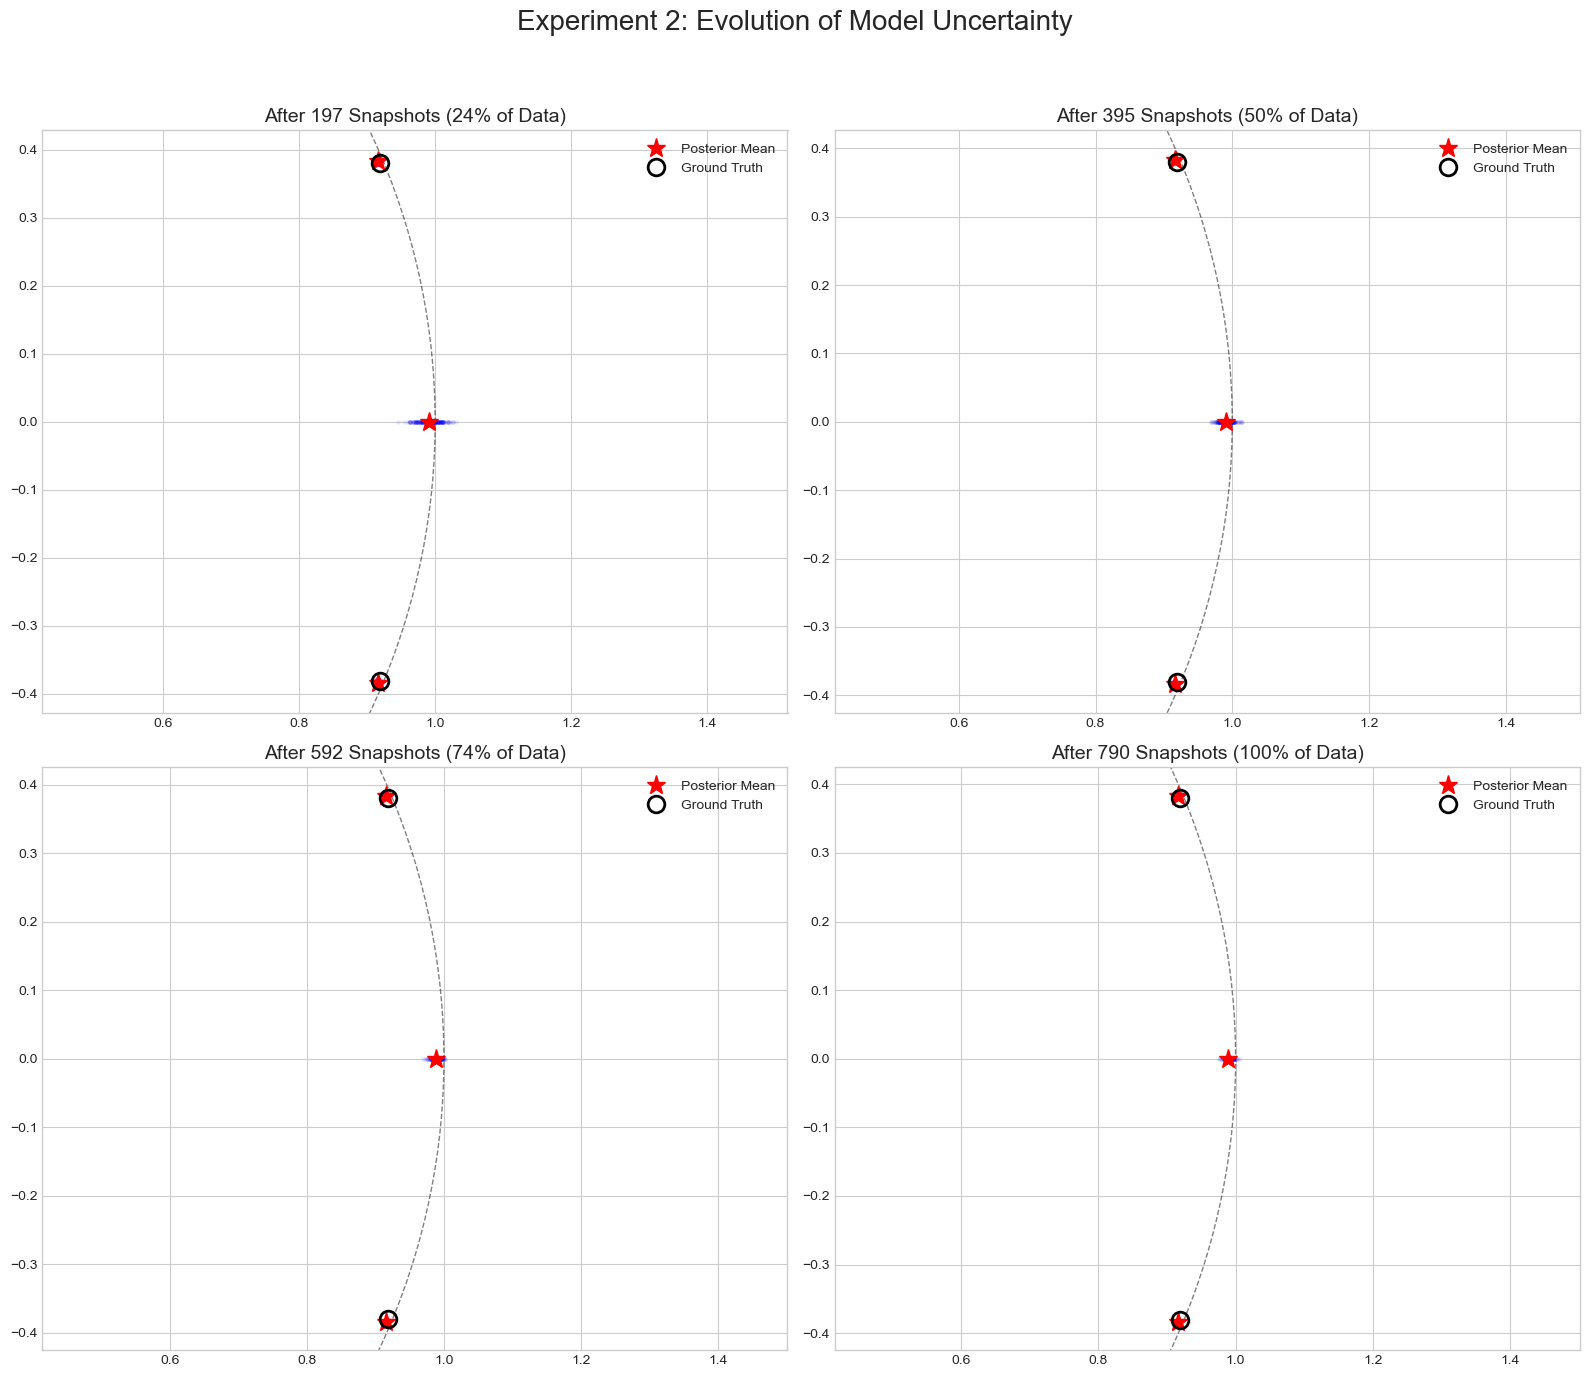

In [14]:


dt = QbData.T1y_flat[1] - QbData.T1y_flat[0]
rank = 6
state_dim = QbData.Y1_flat.shape[0]
X1, X2, U = QbData.Y1_flat, QbData.Y2_flat, QbData.U1y_flat
ts = QbData.T1y_flat

# --- 2. Fit the Bayesian_biDMD model ---
# This uses the updated class that saves a complete history
print("Fitting Bayesian_biDMD model and tracking uncertainty...")
model_bayes = dmd.Bayesian_biDMD(X2, X1, U, ts, rank=rank, forgetting_factor=1.0)
model_bayes.rank = rank
model_bayes.fit()

# --- 3. Analyze Uncertainty at Different Stages ---
num_snapshots = X1.shape[1]
checkpoints = [int(num_snapshots * p) for p in [0.25, 0.50, 0.75, 1.0]]
n_samples = 200



plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()
fig.suptitle('Experiment 2: Evolution of Model Uncertainty', fontsize=20)

U_r, _, _ = np.linalg.svd(X1, full_matrices=False)
U_r = U_r[:, :rank]

# --- 4. Loop through checkpoints to sample and plot ---
for i, k in enumerate(checkpoints):
    # CORRECTED LOGIC HERE:
    # We access the history list at index `k-1` to get the dictionary of the model's state
    # after the k-th snapshot has been processed.
    historical_state = model_bayes.history[k - 1]
    print(f"Analyzing posterior at snapshot {k}/{num_snapshots}...")
    
    # Temporarily set the model's current state to its historical state
    # This allows us to use the `sample_posterior_G` method correctly
    model_bayes.M_G = historical_state['M_G']
    model_bayes.K_G = historical_state['K_G']
    model_bayes.Psi_G = historical_state['Psi_G']
    model_bayes.nu_G = historical_state['nu_G']
    
    # Now, draw samples from this historical posterior state
    g_samples = model_bayes.sample_posterior_G(n_samples=n_samples)
    
    sampled_eigs = []
    for g_sample in g_samples:
        A_sample = g_sample[:, :state_dim]
        A_reduced_sample = U_r.T @ A_sample @ U_r
        eigvals, _ = np.linalg.eig(A_reduced_sample)
        sampled_eigs.append(eigvals)
        
    ax = axes[i]
    for eigs in sampled_eigs:
        ax.plot(np.real(eigs), np.imag(eigs), 'b.', markersize=5, alpha=0.05)
    
    # Calculate the mean eigenvalues from the historical mean operator
    mean_A = historical_state['M_G'][:, :state_dim]
    mean_A_reduced = U_r.T @ mean_A @ U_r
    mean_eigs, _ = np.linalg.eig(mean_A_reduced)
    
    ax.plot(np.real(mean_eigs), np.imag(mean_eigs), 'r*', markersize=14, label='Posterior Mean')
    ax.plot(np.real(true_eigs), np.imag(true_eigs), 'o', markerfacecolor='none', 
             markeredgecolor='k', markersize=12, markeredgewidth=2, label='Ground Truth')
    
    ax.set_title(f'After {k} Snapshots ({int(k/num_snapshots*100)}% of Data)', fontsize=14)
    ax.axis('equal')
    ax.grid(True)
    ax.legend()

    unit_circle = plt.Circle((0,0), 1, color='k', fill=False, linestyle='--', alpha=0.5)
    ax.add_artist(unit_circle)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

--- Running Experiment 3 (Final Robust Code): Tracking a Time-Varying System ---
Fitting Bayesian_biDMD with a forgetting factor (lambda < 1)...
Starting Bayesian Incremental Fit. Total Snapshots: 999
Bayesian fit complete.


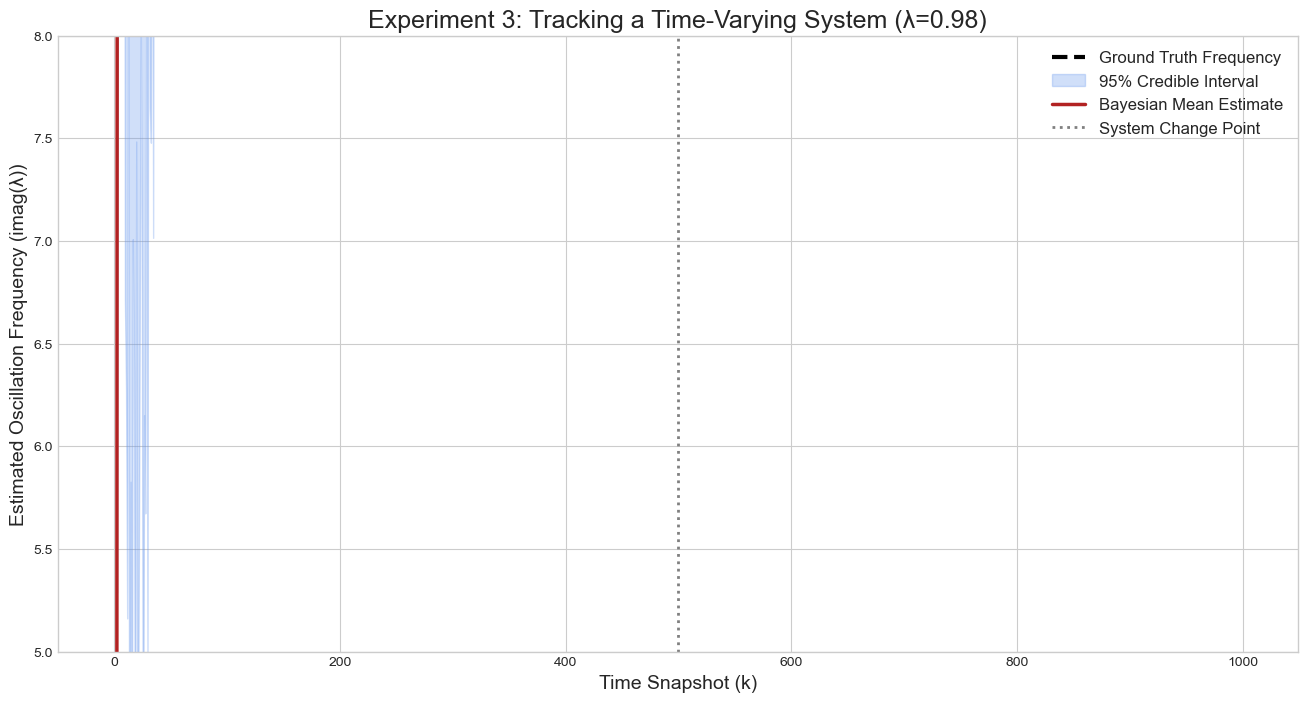

In [15]:
# In your notebook, replace the cell for Experiment 3 with this one.

print("--- Running Experiment 3 (Final Robust Code): Tracking a Time-Varying System ---")
# [ ... The Data Generation code (section 1) remains exactly the same ... ]
# --- 1. Generate a Time-Varying Dataset ---
rank, state_dim, control_dim = 6, 3, 1
num_snapshots, change_point, dt = 1000, 500, 0.02
H0_initial, H0_final = 2*np.pi*qt.sigmaz(), 2.5*np.pi*qt.sigmaz()
H_control = np.pi*qt.sigmax()
dissipation = [np.sqrt(0.05) * qt.sigmaz()]
U = np.random.randn(control_dim, num_snapshots) * 0.1
X = np.zeros((state_dim, num_snapshots))
rho0 = qt.ket2dm(qt.basis(2, 1))
X[:, 0] = [qt.expect(qt.sigmax(), rho0), qt.expect(qt.sigmay(), rho0), qt.expect(qt.sigmaz(), rho0)]
for k in range(num_snapshots - 1):
    H0 = H0_initial if k < change_point else H0_final
    H = H0 + U[0, k] * H_control
    result = qt.mesolve(H, rho0, [0, dt], c_ops=dissipation, e_ops=[])
    rho0 = result.states[-1]
    X[:, k+1] = [qt.expect(qt.sigmax(), rho0), qt.expect(qt.sigmay(), rho0), qt.expect(qt.sigmaz(), rho0)]
X1, X2, U_fit, ts_fit = X[:, :-1], X[:, 1:], U[:, :-1], np.arange(num_snapshots-1)*dt

# --- 2. Fit the Bayesian_biDMD model ---
print("Fitting Bayesian_biDMD with a forgetting factor (lambda < 1)...")
model_bayes_tracking = dmd.Bayesian_biDMD(X2, X1, U_fit, ts_fit, rank=rank, forgetting_factor=0.98)

model_bayes_tracking.fit()

# --- 3. Analyze and Plot the Results ---
# [ ... Ground truth frequency calculation remains the same ... ]
L_initial = qt.liouvillian(H0_initial, c_ops=dissipation)
poles_initial = L_initial.eigenenergies()
freq_initial = np.max(np.abs(np.imag(poles_initial)))
L_final = qt.liouvillian(H0_final, c_ops=dissipation)
poles_final = L_final.eigenenergies()
freq_final = np.max(np.abs(np.imag(poles_final)))

tracked_eigs_imag, upper_bounds, lower_bounds = [], [], []
U_r, _, _ = np.linalg.svd(X1, full_matrices=False)
U_r = U_r[:, :rank]

for state in model_bayes_tracking.history:
    A_mean = state['M_G'][:, :state_dim]
    A_reduced = U_r.T @ A_mean @ U_r
    mean_eigs, _ = np.linalg.eig(A_reduced)
    tracked_eigs_imag.append(np.max(np.imag(np.log(mean_eigs[np.abs(mean_eigs)>0.1])/dt)))

    model_bayes_tracking.M_G, model_bayes_tracking.K_G, model_bayes_tracking.Psi_G, model_bayes_tracking.nu_G = state.values()
    samples = model_bayes_tracking.sample_posterior_G(n_samples=50)
    
    sample_freqs = []
    for g in samples:
        A_s = g[:, :state_dim]
        A_r_s = U_r.T @ A_s @ U_r
        e_s, _ = np.linalg.eig(A_r_s)
        
        # --- FIX FOR LOG WARNING ---
        try:
            # Filter for complex eigenvalues before taking the log
            valid_eigs = e_s[np.abs(np.imag(e_s)) > 1e-6]
            if len(valid_eigs) > 0:
                freq = np.max(np.imag(np.log(valid_eigs)/dt))
                sample_freqs.append(freq)
        except (ValueError, IndexError):
            # Gracefully ignore samples that produce no valid eigenvalues
            continue
            
    if sample_freqs:
        lower_bounds.append(np.percentile(sample_freqs, 2.5))
        upper_bounds.append(np.percentile(sample_freqs, 97.5))
    else: # If no valid samples were found, reuse the last valid bound
        lower_bounds.append(lower_bounds[-1] if lower_bounds else 0)
        upper_bounds.append(upper_bounds[-1] if upper_bounds else 0)

# [ ... Plotting code remains exactly the same ... ]
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))
plt.plot([0, change_point-1], [freq_initial, freq_initial], 'k--', linewidth=3, label='Ground Truth Frequency')
plt.plot([change_point, num_snapshots-1], [freq_final, freq_final], 'k--', linewidth=3)
plt.fill_between(range(len(tracked_eigs_imag)), lower_bounds, upper_bounds, color='cornflowerblue', alpha=0.3, label='95% Credible Interval')
plt.plot(tracked_eigs_imag, color='firebrick', linewidth=2.5, label='Bayesian Mean Estimate')
plt.axvline(x=change_point, color='gray', linestyle=':', linewidth=2, label='System Change Point')
plt.title('Experiment 3: Tracking a Time-Varying System (λ=0.98)', fontsize=18)
plt.xlabel('Time Snapshot (k)', fontsize=14)
plt.ylabel('Estimated Oscillation Frequency (imag(λ))', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.ylim(5, 8)
plt.show()

In [19]:


# 1. --- Create a known time-varying system ---
state_dim = 2
num_snapshots = 1000
change_point = 500

# System dynamics before the change
A_initial = np.array([[0.9, 0.1],
                      [-0.1, 0.9]])
true_eig_initial = np.linalg.eigvals(A_initial)

# System dynamics after the change
A_final = np.array([[0.5, 0.2],
                    [-0.2, 0.5]])
true_eig_final = np.linalg.eigvals(A_final)

# Generate the data
X = np.zeros((state_dim, num_snapshots + 1))
X[:, 0] = [1.0, 0.5] # Initial state

for k in range(num_snapshots):
    if k < change_point:
        X[:, k+1] = A_initial @ X[:, k]
    else:
        X[:, k+1] = A_final @ X[:, k]

X1 = X[:, :-1]
X2 = X[:, 1:]
U = np.zeros((1, num_snapshots)) # No control input for this simple test
ts =np.arange(num_snapshots)*dt
# 2. --- Fit both an adaptive and a static model ---

# Model A: Your adaptive model
model_adaptive = dmd.Bayesian_biDMD(X2, X1, U, ts, rank=state_dim, forgetting_factor=0.95)
model_adaptive.fit()

# Model B: A non-adaptive (static) model
model_static = dmd.Bayesian_biDMD(X2, X1, U, ts,  rank=state_dim, forgetting_factor=1.0)
model_static.fit()

# 3. --- Extract and plot the results ---

def get_eigenvalue_history(model):
    """Extracts the real part of the first eigenvalue from model history."""
    eigs_history = []
    for state in model.history:
        # Get the estimated A matrix
        A_est = state['M_G'][:, :model.rank]
        eigs = np.linalg.eigvals(A_est)
        eigs_history.append(eigs[0].real) # Track the real part of the first eigenvalue
    return eigs_history

adaptive_eigs = get_eigenvalue_history(model_adaptive)
static_eigs = get_eigenvalue_history(model_static)

# Create the plot
plt.figure(figsize=(12, 7))
plt.axhline(true_eig_initial[0].real, color='k', linestyle='--', label='Ground Truth (Initial)')
plt.axhline(true_eig_final[0].real, color='k', linestyle=':', label='Ground Truth (Final)')
plt.axvline(change_point, color='r', linestyle='-', lw=2, label='System Change Point')

plt.plot(adaptive_eigs, label='Adaptive Model (lambda < 1)', color='blue', lw=2)
plt.plot(static_eigs, label='Static Model (lambda = 1)', color='gray', lw=2)

plt.title('Model Comparison: Tracking a Time-Varying System', fontsize=16)
plt.xlabel('Time Snapshot (k)', fontsize=12)
plt.ylabel('Estimated Real Part of Eigenvalue', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

E:\Quntum Technology\DMD for Quantum\Mygit\dmdlab\dmdlab\dmd.py:346: RuntimeWarning: divide by zero encountered in divide
  left = self.X2 @ dag(Vgt) @ np.diag(1 / Sg)
E:\Quntum Technology\DMD for Quantum\Mygit\dmdlab\dmdlab\dmd.py:347: RuntimeWarning: invalid value encountered in matmul
  self.A = left @ dag(Ug[:n, :])
E:\Quntum Technology\DMD for Quantum\Mygit\dmdlab\dmdlab\dmd.py:348: RuntimeWarning: invalid value encountered in matmul
  self.B = left @ dag(Ug[n:, :])


LinAlgError: Array must not contain infs or NaNs

In [20]:
print(ts)

[ 0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18  0.2   0.22
  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42  0.44  0.46
  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62  0.64  0.66  0.68  0.7
  0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86  0.88  0.9   0.92  0.94
  0.96  0.98  1.    1.02  1.04  1.06  1.08  1.1   1.12  1.14  1.16  1.18
  1.2   1.22  1.24  1.26  1.28  1.3   1.32  1.34  1.36  1.38  1.4   1.42
  1.44  1.46  1.48  1.5   1.52  1.54  1.56  1.58  1.6   1.62  1.64  1.66
  1.68  1.7   1.72  1.74  1.76  1.78  1.8   1.82  1.84  1.86  1.88  1.9
  1.92  1.94  1.96  1.98  2.    2.02  2.04  2.06  2.08  2.1   2.12  2.14
  2.16  2.18  2.2   2.22  2.24  2.26  2.28  2.3   2.32  2.34  2.36  2.38
  2.4   2.42  2.44  2.46  2.48  2.5   2.52  2.54  2.56  2.58  2.6   2.62
  2.64  2.66  2.68  2.7   2.72  2.74  2.76  2.78  2.8   2.82  2.84  2.86
  2.88  2.9   2.92  2.94  2.96  2.98  3.    3.02  3.04  3.06  3.08  3.1
  3.12  3.14  3.16  3.18  3.2   3.22  3.24  3.26  3.28

--- Verification against Batch biDMD ---
Difference in A matrices (norm): 0.000000
Difference in B matrices (norm): 0.000000

SUCCESS: The incremental model results match the batch model results closely.

--- Plotting Convergence ---


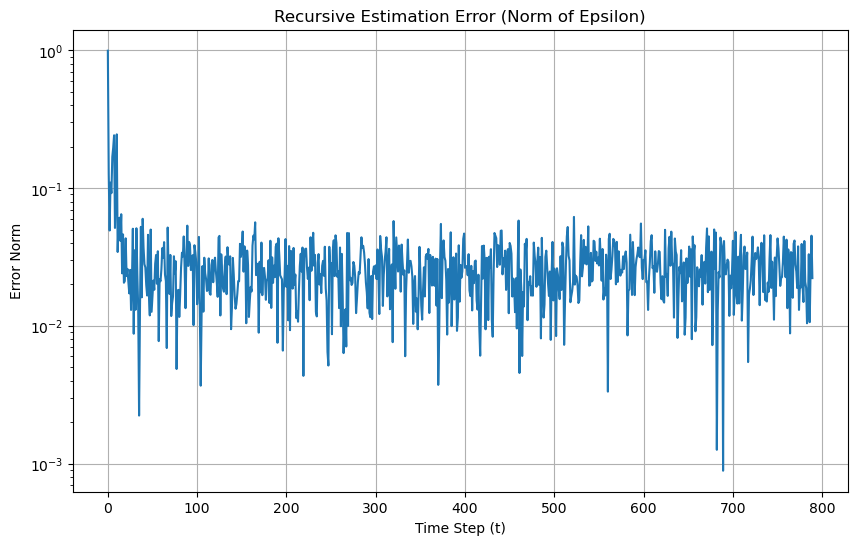

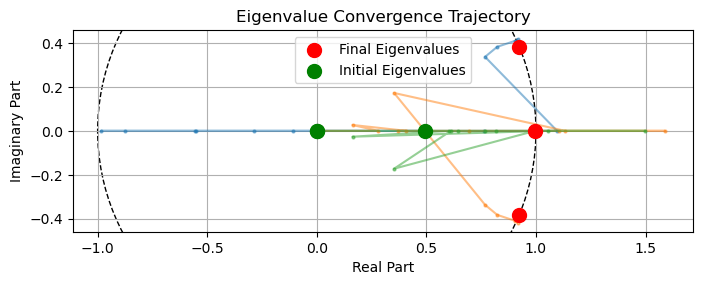

In [9]:

import matplotlib.pyplot as plt


# --- 1. Verification: Compare with Batch biDMD ---

print("--- Verification against Batch biDMD ---")

# Run the standard batch biDMD on the same data
batch_model = dmd.biDMD(
    QbData.Y2_flat, 
    QbData.Y1_flat, 
    QbData.U1y_flat, 
    QbData.T1y_flat, 
    threshold_type='count', 
    threshold=6
)

# Your incremental model is already run and stored in 'model'
incremental_model = model1

# Compare the learned A matrices
# We use the Frobenius norm of the difference. A smaller number is better.
diff_A = np.linalg.norm(batch_model.A - incremental_model.A)
print(f"Difference in A matrices (norm): {diff_A:.6f}")

# Compare the learned B matrices
diff_B = np.linalg.norm(batch_model.B - incremental_model.B)
print(f"Difference in B matrices (norm): {diff_B:.6f}")

if diff_A < 1e-6 and diff_B < 1e-6:
    print("\nSUCCESS: The incremental model results match the batch model results closely.")
else:
    print("\nWARNING: The incremental model results differ significantly from the batch model.")

# --- 2. Plot Estimation Error ---

print("\n--- Plotting Convergence ---")

plt.figure(figsize=(10, 6))
plt.plot(incremental_model.error_history)
plt.title('Recursive Estimation Error (Norm of Epsilon)')
plt.xlabel('Time Step (t)')
plt.ylabel('Error Norm')
plt.grid(True)
plt.yscale('log') # Log scale is often useful for viewing convergence
plt.show()


# --- 3. Plot Eigenvalue Convergence ---

# Use the new plotting function from the dmd.plot module
# Note: You might need to restart your kernel for the new function to be imported
dmd.plot.plot_eigs_history(incremental_model.eigs_history, figsize=(8, 8))
plt.show()


0.8917022004702574
0.9220324493442158
0.8500114374817345


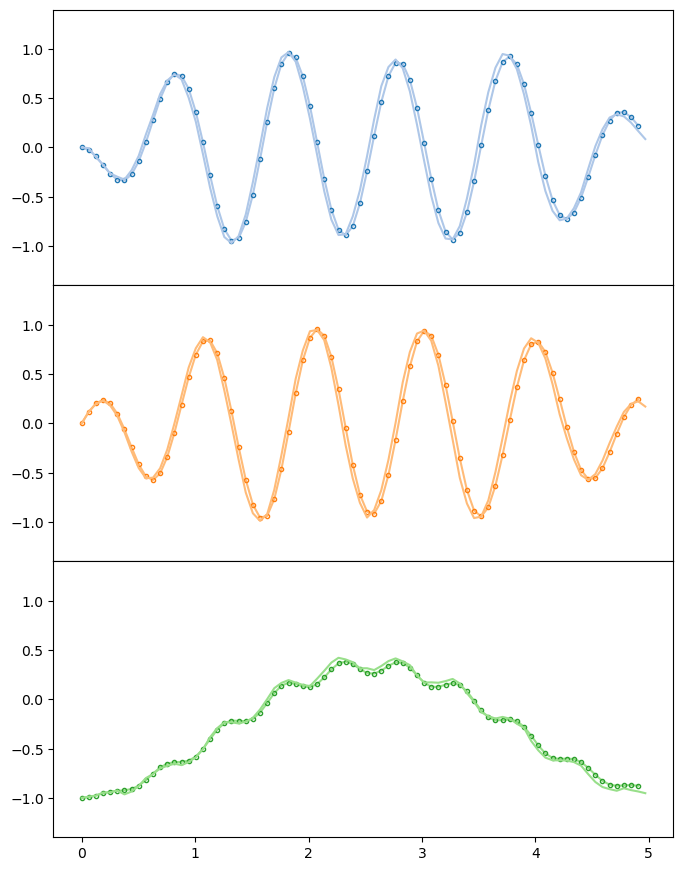

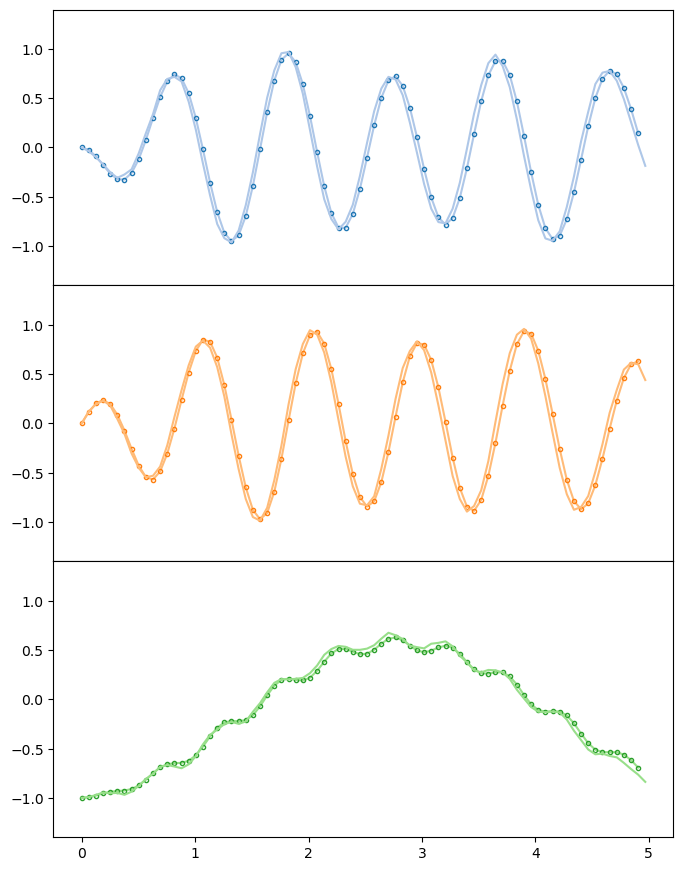

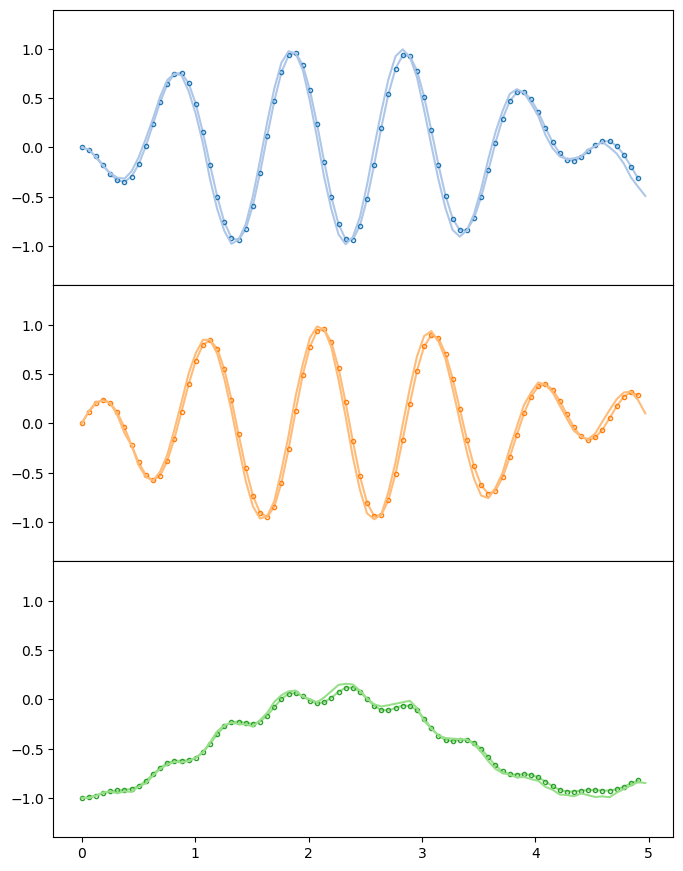

In [12]:
# Plot some of the training data and the training fit
for j in range(min(n_experiments, 3)):
    fig, axes = plt.subplots(3, 1, figsize=[8,10.75])
    X_predict = model.predict_dst(control=QbData.Uy[j], x0=QbData.Y[j][:,0])
    print(QbData.Args_List[j]['Omega']/2/np.pi)
    for m in range(n_measure):
        axes[m].plot(QbData.Ty[j][:-1], X_predict[m,:-1], color=cmap2(2*m+1), marker='o', markeredgecolor=cmap(m), markerfacecolor='None', ms=3)
        axes[m].plot(QbData.Ty[j], QbData.Y[j][m], color=cmap2(2*m+1))
        axes[m].set_ylim([-1.4,1.4])    
    [ax.set_xticks([]) for ax in axes.flatten()[:-1]]
    fig.subplots_adjust(wspace=0, hspace=0)

0.8917022004702574
0.9220324493442158
0.8500114374817345


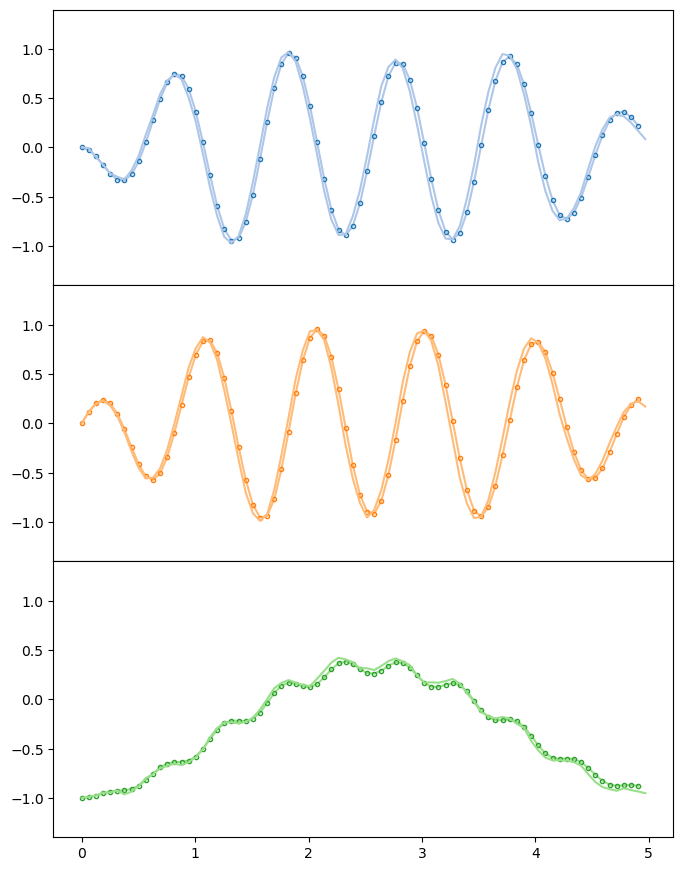

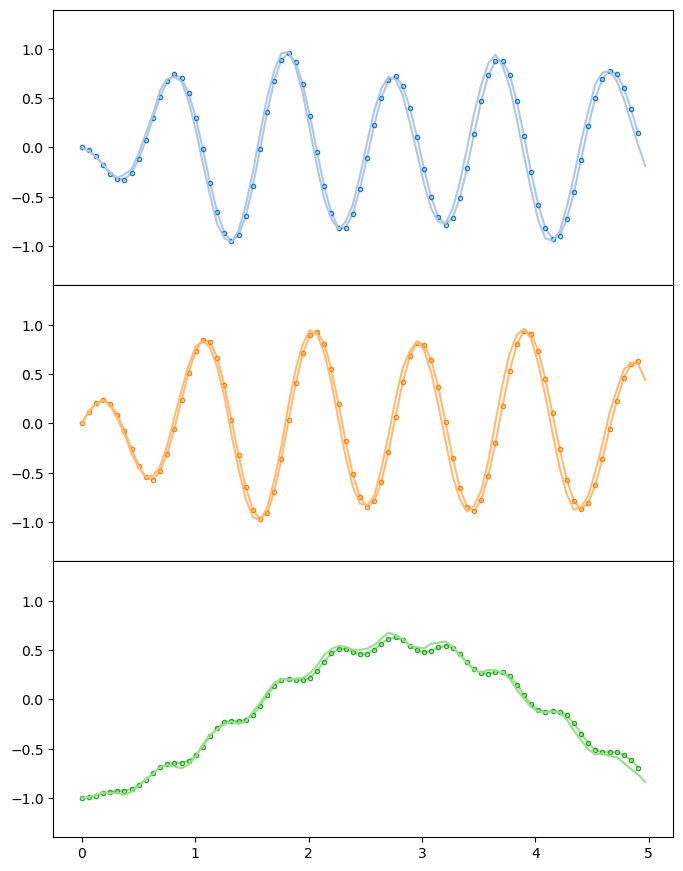

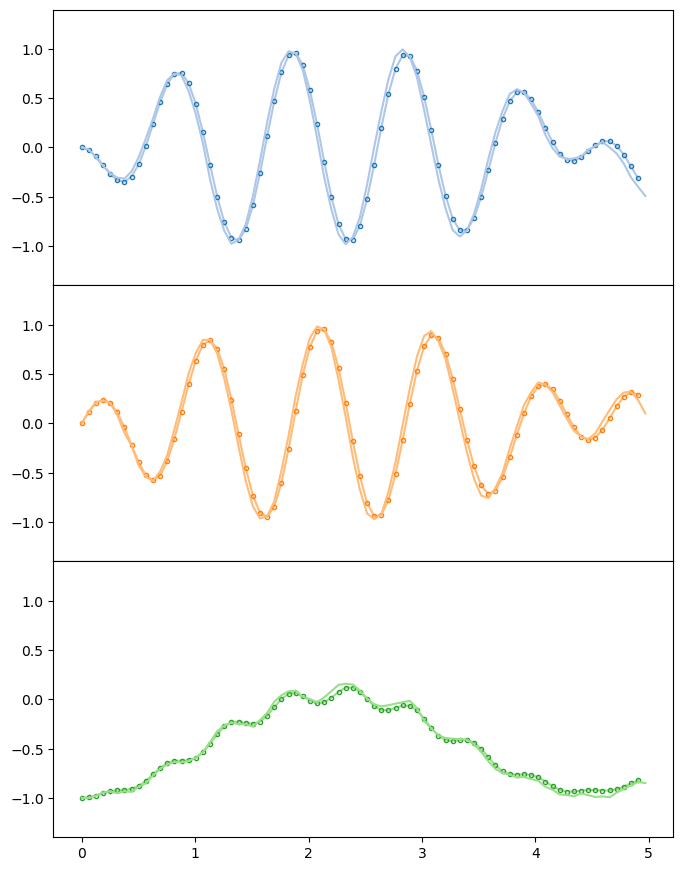

In [13]:
# Plot some of the training data and the training fit
for j in range(min(n_experiments, 3)):
    fig, axes = plt.subplots(3, 1, figsize=[8,10.75])
    X_predict = model1.predict_dst(control=QbData.Uy[j], x0=QbData.Y[j][:,0])
    print(QbData.Args_List[j]['Omega']/2/np.pi)
    for m in range(n_measure):
        axes[m].plot(QbData.Ty[j][:-1], X_predict[m,:-1], color=cmap2(2*m+1), marker='o', markeredgecolor=cmap(m), markerfacecolor='None', ms=3)
        axes[m].plot(QbData.Ty[j], QbData.Y[j][m], color=cmap2(2*m+1))
        axes[m].set_ylim([-1.4,1.4])    
    [ax.set_xticks([]) for ax in axes.flatten()[:-1]]
    fig.subplots_adjust(wspace=0, hspace=0)

Now use the model and the estimated resonance frequency to see what our prediction is for an example pulse that is on resonance. The prediction is made using only the model, a given initial state and the new control pulse.

You might also consider running a new experiment where you put the estimated bare frequency into your list and try to get advantages from this feedback.

c:\ProgramData\anaconda3\envs\QuantumD\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


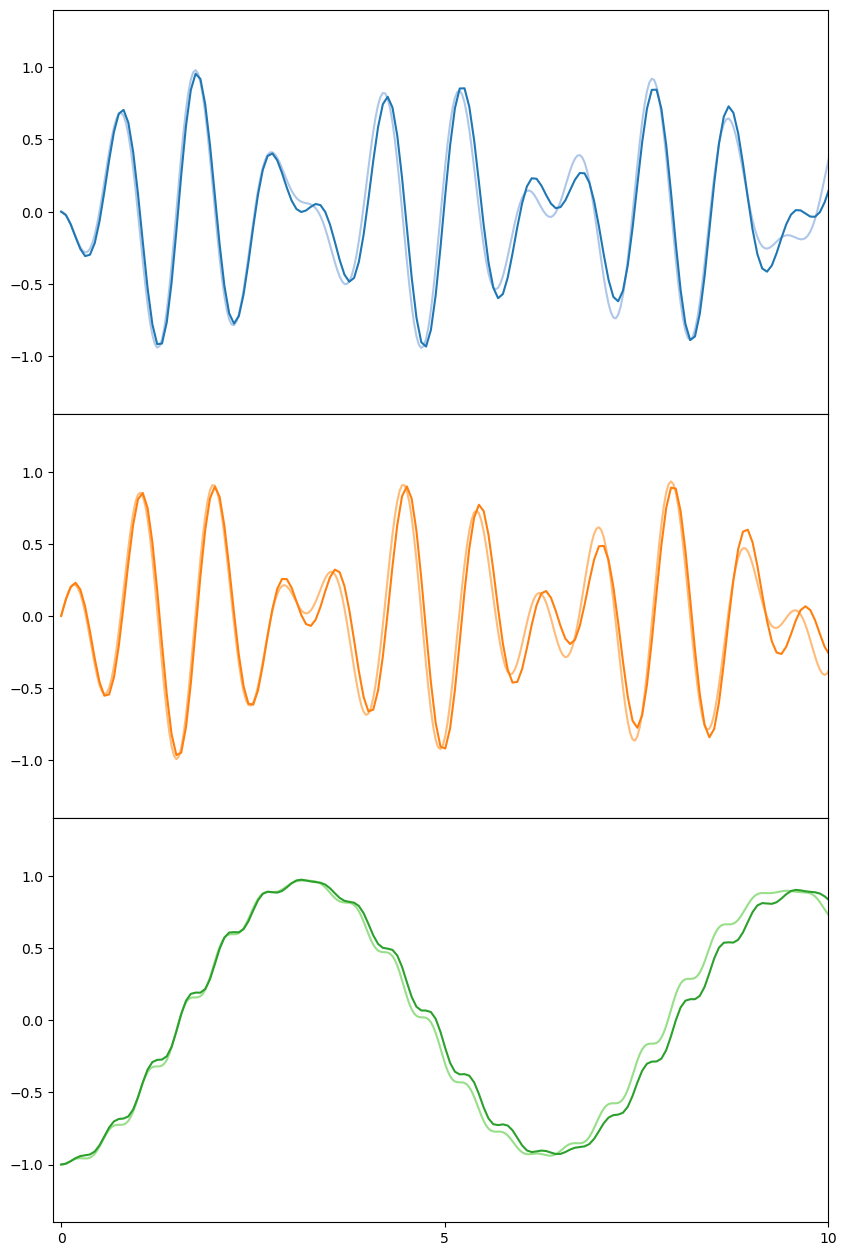

In [15]:
# Simulate the testing dynamics using the est_bare from the previous section
c_args_test = {'Omega': 2*np.pi*est_bare, 'u': lambda t: V0*np.ones_like(t)}
result_lab_test = qt.mesolve(H_lab, psi0, ts_test, dissipation, measure_list, args=c_args_test)

# Collect test data
skip = sim_discretization//m_discretization
result = np.array(result_lab_test.expect)
X = result[:,::skip]
T1 = ts_test[::skip]
U1 = fc_lab(T1, c_args_test).reshape(1,-1)
X_predict = model1.predict_dst(control=U1, x0=X[:,0])

# Plot the prediction
fig, axes = plt.subplots(3,1, figsize=[10,15.75])
for m in range(n_measure):
    axes[m].plot(ts_test, result[m], color=cmap2(2*m+1),label=measure_name[m])
    axes[m].plot(T1, X_predict[m],color=cmap2(2*m))
    axes[m].set_ylim([-1.4,1.4])
    axes[m].set_xlim([-.1,10])
    
for m in range(n_measure-1):
    axes[m].set_xticks([])
axes[-1].set_xticks([0,5,10])
fig.subplots_adjust(wspace=0, hspace=0)

## A variation on Example 1

Suppose you already know the resonance frequency of your qubit and you are only interested in checking up on the model for your qubit in the interaction frame. For a weakly coupled dipole interaction, the rotating wave approximation will allow us to treat the model control as the envelope on some carrier at (an approximate) resonance value.

The Hamiltonian in the lab frame is
\begin{equation}
    H_{\mathrm{LP}}(t) = \frac{\Delta}{2} \sigma_z + V \cos(\Omega t) \sigma_x \,.
\end{equation}

The Hamiltonian in the rotating frame is
\begin{equation}
    \tilde{H}_{\mathrm{LP}}(t)
    =\underbrace{\frac{\Omega}{2} \mathbb{1}+\frac{\left(\Delta-\Omega\right)}{2} \sigma_z+\frac{V}{2} \sigma_x}_{\text {Rotating Wave Approximation }}
    +\frac{V}{2}\left( \cos (2 \Omega t) \sigma_x - \sin (2 \Omega t) \sigma_y  \right) \,.
\end{equation}

The tilde refers to the fact that this new Hamiltonian describes the dynamics of a state $|\tilde{\psi}\rangle$ where some of the time dependence has been split off to act on the operators such that $|\psi\rangle = P(t,0)|\tilde{\psi}\rangle $.

Recall that changing to the rotating frame means applying a transformation to the operators:
\begin{equation}
    \tilde{H}_{\mathrm{LP}}(t) = P^{\dagger} H_{\mathrm{LP}}(t) P - i P^{\dagger} \dot{P}_{t} \,.
\end{equation}

Here, we use $P(t,0) = \exp{i \frac{\Omega t}{2} \left(\mathbb{1} - \sigma_z \right)}$ because it turns out to be equal to the Floquet operator (it's the obvious rotation around the z-axis we'd use to go to a rotating or interaction frame, adjusted for periodicity).

Note that for a Hamiltonian with a circularly polarized drive, the rotating wave approximation is actually exact and time-independent. For reference, a circularly polarized system has a the Hamiltonian in the lab frame given by
\begin{equation}
    H_{\mathrm{CP}}(t) = \frac{\Delta}{2} \sigma_z + \frac{V}{2} \left( \cos(\Omega t) \sigma_x + \sin(\Omega t) \sigma_y \right) 
    \Rightarrow  \tilde{H}_{\mathrm{CP}} = \frac{\Omega}{2} \mathbb{1}+\frac{\left(\Delta-\Omega\right)}{2} \sigma_z+\frac{V}{2} \sigma_x \,.
\end{equation}

The conclusion of our discussion is that we can treat the envelope $V(t)=V_0 f(t)$ as the control input for a model of measurements in the rotating frame. We'll explore later the connections between the rotating frame and Floquet theory.

In the code below we explore the differences between the frames. Consider changing the coupling $V_0$ between $1$ and $0.1$ to see the differences between the RWA and the rotating frame emerge at stronger coupling strength (but you should also consider descreasing or increasing the final time by a similar order of magnitude, respectively).

Text(0.5, 1.0, 'Rotating wave approximation')

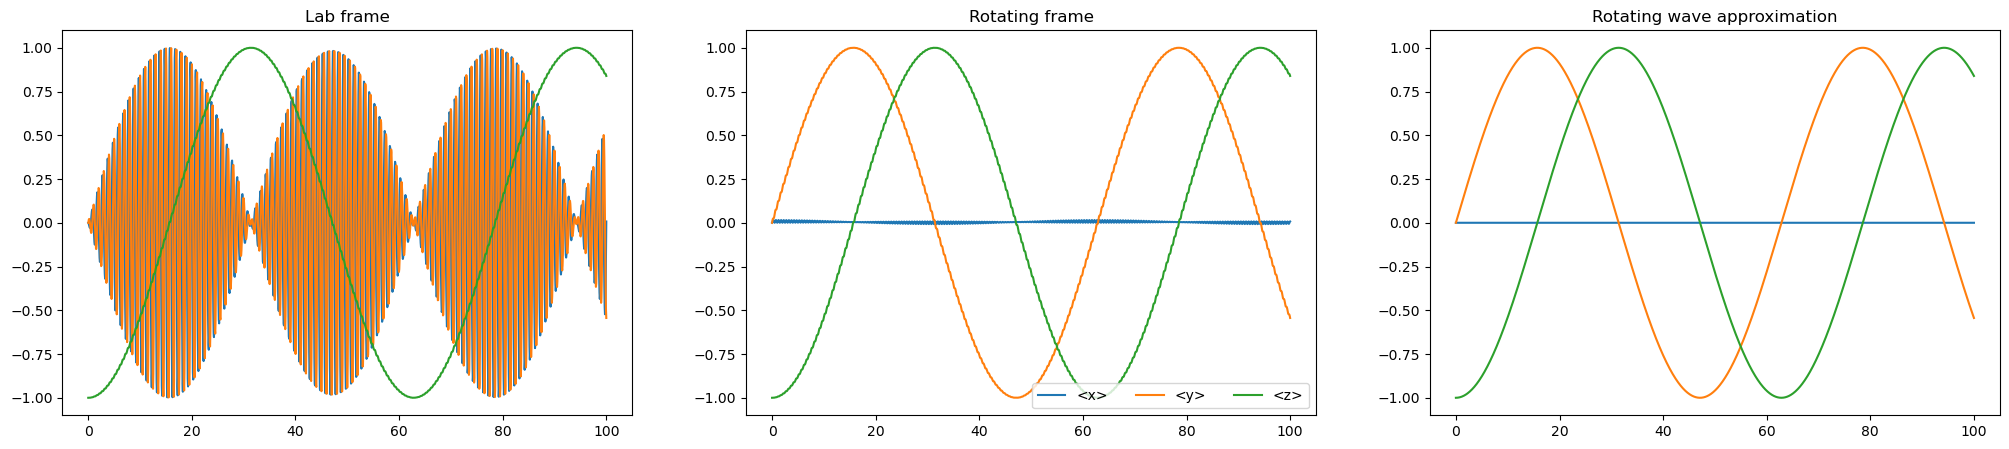

In [16]:
# Qubit frequency
w0 = 1 
Delta = 2*np.pi*w0

# Carrier frequency
w1 = 1 
Omega = 2*np.pi*w1

# Coupling strength of control
# -- Stronger coupling makes the RWA less accurate (compare .1 and 1)
V0 = .1

# Time series parameters
sim_discretization = 16
sim_dt =  2*np.pi/Omega/sim_discretization
dt =  2*np.pi/Omega/m_discretization
t0 = 0
tf = 10/V0
ts = np.linspace(t0, tf, int((tf-t0)//sim_dt), endpoint=True)

# Choose measurements
measure_list = [qt.sigmax(), qt.sigmay(), qt.sigmaz()] 
measure_name = ['<{}>'.format(s) for s in ['x','y','z']]
n_measure = len(measure_list)

# Hamiltonians
# -- Rotating frame
H0 = Omega/2*qt.identity(2) + (Delta - Omega)/2*qt.sigmaz()
pulse_minus = lambda t, args: (1 + np.exp(-2j*t*args['Omega']))/2*args['u'](t)
pulse_plus = lambda t, args: (1 + np.exp(2j*t*args['Omega']))/2*args['u'](t)
H_rot = [H0, [V0*qt.sigmam(), pulse_minus], [V0*qt.sigmap(), pulse_plus]]

# -- Rotating wave approximation in the rotating frame
pulse_rwa = lambda t, args: args['u'](t)/2
H_rwa = [H0, [V0*qt.sigmax(), pulse_rwa]]

# -- Lab frame (Linear Polarization)
H0_lab = Delta/2*qt.sigmaz()
pulse_lab = lambda t, args: args['u'](t)*np.cos(args['Omega']*t)
H_lab = [H0_lab, [V0*qt.sigmax(), pulse_lab]]

# Simulate some dynamics
psi0 = qt.basis(2,1)
c_args = {'Omega': Omega, 'u': lambda t: np.ones_like(t)}
result_rot = qt.mesolve(H_rot, psi0, ts, [], measure_list, args=c_args)
result_rwa = qt.mesolve(H_rwa, psi0, ts, [], measure_list, args=c_args)
result_lab = qt.mesolve(H_lab, psi0, ts, [], measure_list, args=c_args)

# Plot
fig, axes = plt.subplots(1,3,figsize=[25,5])
for i in range(n_measure):
    axes[1].plot(ts, result_rot.expect[i], color=cmap(i), label=measure_name[i])
    axes[2].plot(ts, result_rwa.expect[i], color=cmap(i))
    axes[0].plot(ts, result_lab.expect[i], color=cmap(i))
    
axes[1].legend(ncol=3)
axes[0].set_title('Lab frame')
axes[1].set_title('Rotating frame')
axes[2].set_title('Rotating wave approximation')

We will take data from the rotating frame as our training set and fit a bilinear model assuming the rotating wave approximation so the control envelope is our input.

We then see how well we can predict with a different control envelope. Also, we are using reasonable experimental values in this example (so reasonable statistical noise and errors in the carrier, and some Markovian dissipation).

<>:69: SyntaxWarning: invalid escape sequence '\p'
<>:69: SyntaxWarning: invalid escape sequence '\p'
C:\Users\fatem\AppData\Local\Temp\ipykernel_26536\3071725528.py:69: SyntaxWarning: invalid escape sequence '\p'
  ax.set_title('Light color is the test value $\pm \sigma$. Dark color is the the model prediction.')
c:\ProgramData\anaconda3\envs\QuantumD\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Control eigenvalues:  [ 0.05981714+0.j         -0.00593971+0.10525988j -0.00593971-0.10525988j]


Text(0.5, 1.0, 'Control operator B')

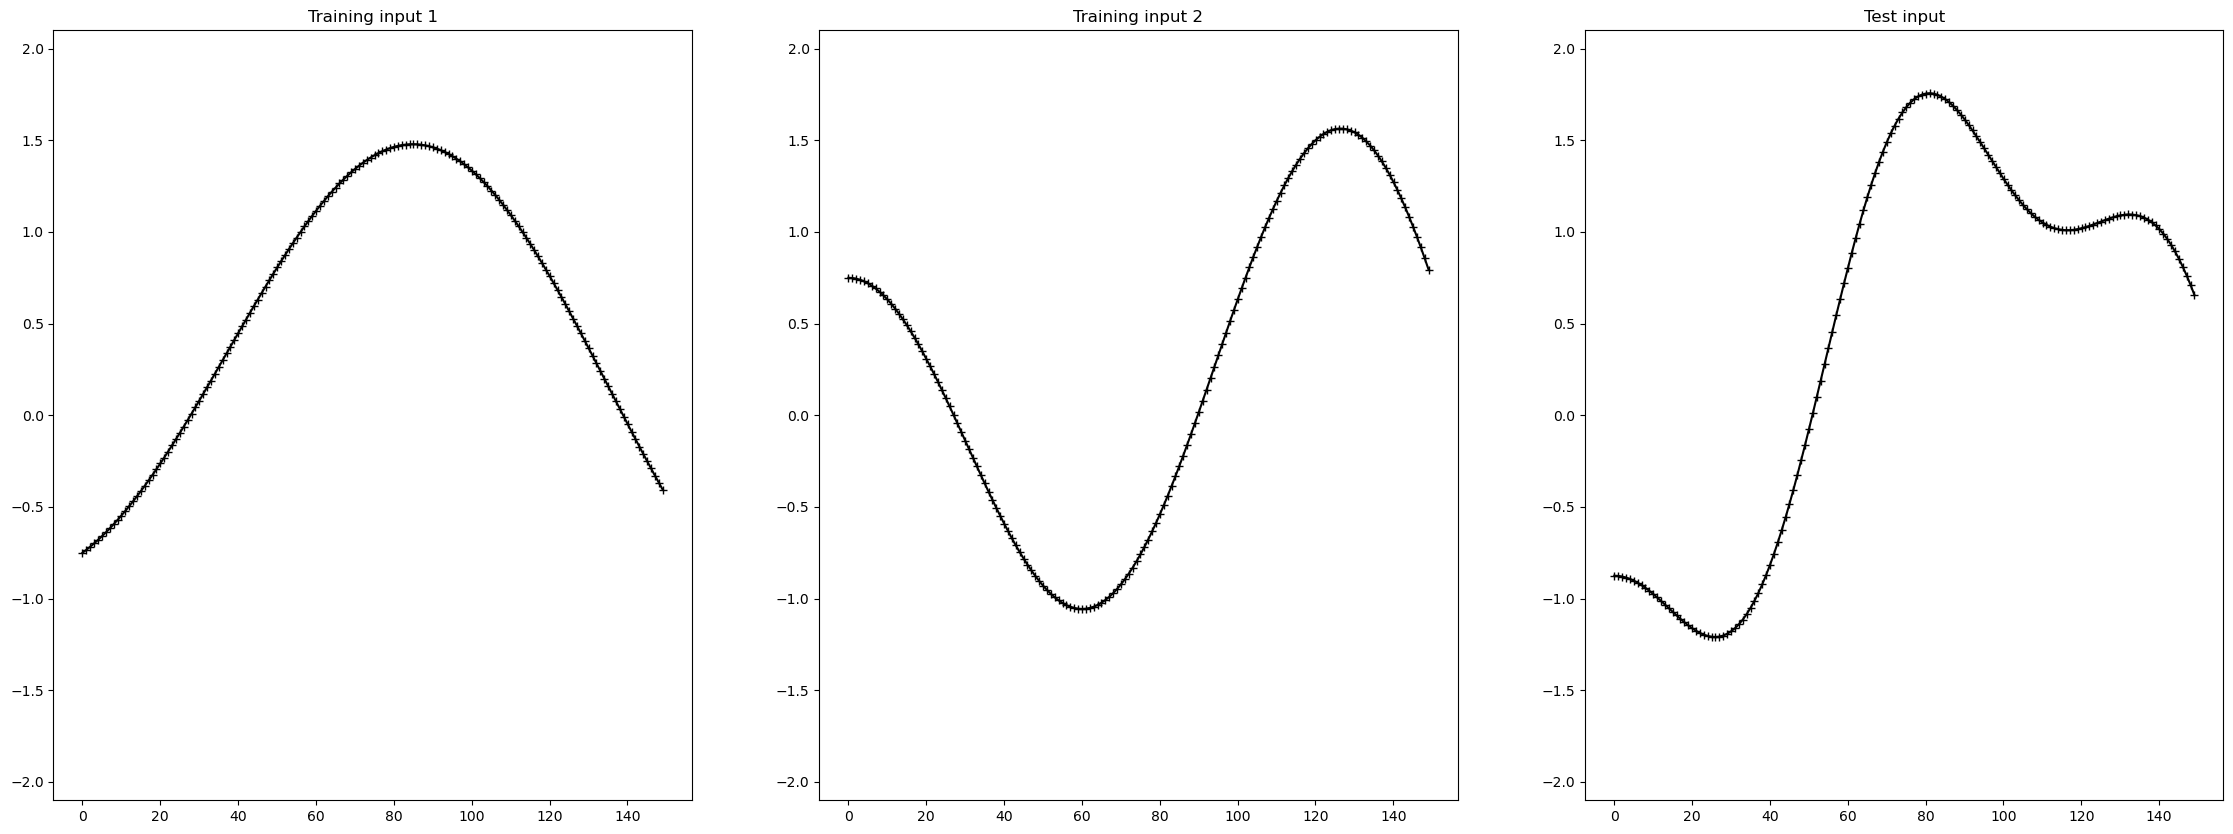

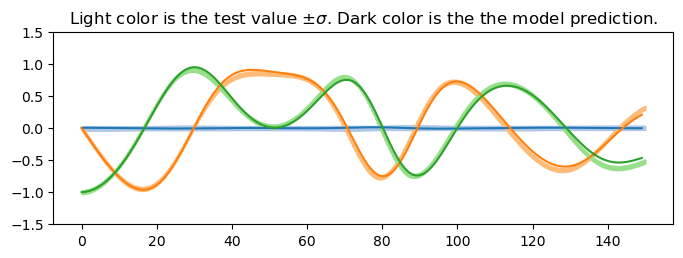

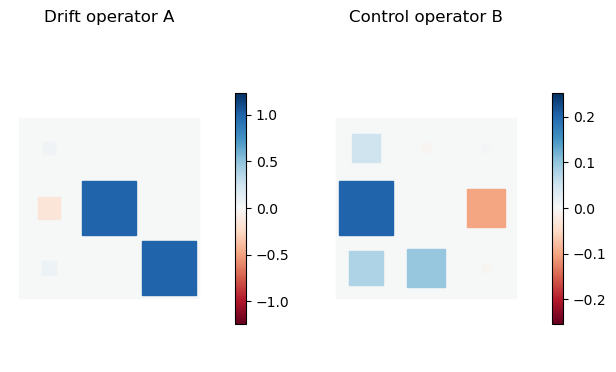

In [18]:
# -- Rotating frame is all we need
V0 = .05
H0 = Omega/2*qt.identity(2) + (Delta - Omega)/2*qt.sigmaz()
pulse_minus = lambda t, args: (1 + np.exp(-2j*t*args['Omega']))/2*args['u'](t)
pulse_plus = lambda t, args: (1 + np.exp(2j*t*args['Omega']))/2*args['u'](t)
H_rot = [H0, [V0*qt.sigmam(), pulse_minus], [V0*qt.sigmap(), pulse_plus]]

# Set measurement certainty
N_measure = 1e3
sigma = 1/np.sqrt(N_measure)

# Time series parameters
sim_discretization = 16
sim_dt =  2*np.pi/Omega/sim_discretization
dt =  2*np.pi/Omega/m_discretization
t0 = 0
tf = 150
ts = np.linspace(t0, tf, int((tf-t0)//sim_dt), endpoint=True)
m_discretization = 1
# -- Measuremetns occur only between skipped points
skip = int(sim_discretization/m_discretization)

# Dissipation
dissipation = [[.04*qt.sigmax()], [.01*qt.sigmam()]]

# Train data
QbData = QubitExperiment()
train_envelope_1 = lambda t: 1.5*np.sin(np.pi*(t-t0)/(tf-t0)) - 1.5*np.cos(1.7*np.pi*(t-t0)/(tf-t0))
train_envelope_2 = lambda t: 2.5*np.cos(2.3*np.pi*(t-t0)/(tf-t0)) - 1*np.cos(1.5*np.pi*(t-t0)/(tf-t0))

for te in [train_envelope_1, train_envelope_2]:
    c_args = {'Omega': Omega, 'u': te}
    result_train = qt.mesolve(H_rot, psi0, ts, dissipation, measure_list, args=c_args)
    X = np.array(result_train.expect)
    Y = X[:, ::skip]
    Y[:,1:] = Y[:,1:] + np.random.randn(*Y[:,1:].shape)*sigma
    Ty = ts[::skip]
    Uy = pulse_rwa(Ty, c_args).reshape(1, -1)
    QbData.save(X, Y, Uy, Ty, c_args)
QbData.finalize()

# Fit a model
model = dmd.ibiDMD(QbData.Y2_flat, QbData.Y1_flat, QbData.U1y_flat, QbData.T1y_flat, threshold=1e-3, threshold_type='percent')

# Test data
test_envelope = lambda t: .25-3*np.cos(1.5*np.pi/(tf-t0)*(t-t0)) + np.cos(4.1*np.pi/(tf-t0)*(t-t0))
c_args_test = {'Omega': Omega, 'u': test_envelope}
result_test = qt.mesolve(H_rot, psi0, ts, dissipation, measure_list, args=c_args_test)
Uy_test = pulse_rwa(Ty, c_args_test).reshape(1, -1)
predict = model.predict_dst(control=Uy_test)

# Plot control
fig,axes = plt.subplots(1,3,figsize=[28,10])
for i in range(2): 
    ax=axes[i]
    ax.plot(Ty, QbData.Uy[i][0], marker='+', color='k')
    ax.set_title('Training input {}'.format(i+1))
ax=axes[2]
ax.plot(Ty, Uy_test[0], marker='+', color='k')
ax.set_title('Test input')
[iax.set_ylim([-2.1,2.1]) for iax in axes]

# Plot test prediction
fig, ax = plt.subplots(1, figsize=[8,2.5])
for m in range(n_measure):
    ax.fill_between(ts, result_test.expect[m]-sigma, result_test.expect[m]+sigma, color=cmap2(2*m+1))
    ax.plot(Ty, predict[m], color=cmap(m))
ax.set_ylim([-1.5,1.5])
ax.set_title('Light color is the test value $\pm \sigma$. Dark color is the the model prediction.')

# In the rotating frame only the B operator has oscillating modes.
print('Control eigenvalues: ', np.linalg.eigvals(model.B))

fig, axes = plt.subplots(1, 2, figsize=[7.5,4])
qt.hinton(model.A/dt, ax=axes[0])
axes[0].set_title('Drift operator A')
qt.hinton(model.B/dt, ax=axes[1])
axes[1].set_title('Control operator B')

There are a number of things we could consider doing to improve this fit. We might want to constrain the eigenvalues to be on the unit circle or give our operators a certain structure using an optimization-based DMD. We might also want to look into higher-order expansions of the discretization; that is, we may look into the way the control appears if you expand the continuous dynamics to $\mathcal{O}(\Delta t^3)$.

# Example 2

## Floquet reshape

If we reshape DMD, we can learn a Floquet Hamiltonian for multiple measurments within a single strobe. We reshape the data such that
$$
    \begin{align}
        \mathbf{X} =&
        \begin{bmatrix}
            x(t_0) & x(t_0 + T) & \dots & x(t_0 + (n-2) T) \\
            x(t_1) & x(t_1 + T) & \dots & x(t_1 + (n-2) T) \\
            \vdots & \vdots & & \vdots  \\
            x(t_{m-1}) & x(t_{m-1} + T) & \dots & x(t_{m-1} + (n-2) T)
        \end{bmatrix} \\
        \mathbf{X'} =&
        \begin{bmatrix}
            x(t_0 + T) & x(t_0 + 2 T) \dots & x(t_0 + (n-1) T) \\
            x(t_1 + T) & x(t_1 + 2 T) \dots & x(t_1 + (n-1) T) \\
            \vdots & & \vdots  \\
            x(t_{m-1} + T) & x(t_{m-1} + 2 T) \dots & x(t_{m-1} + (n-1) T)
        \end{bmatrix}
    \end{align}
$$   
where we take $m$ measurements inside a single period. The DMD algorithm is looking for an operator that takes a step size of 1 period, but it does not matter that we are simultaneously learning this operator for multiple times within a single strobe.

In [19]:
def fshape(data, n_measure, invert=False):
    '''
    Floquet reshape.
    
    data.shape = data_dim, n_measure*n_periods
    
    The idea of the code is the following:
    Initial   ->(data_dim, n_measure*n_periods)
    Transpose ->(n_measure*n_periods, data_dim)
    Reshape   ->(n_periods, n_measure, data_dim)
              ->(n_periods, n_measure*data_dim)
    Transpose ->(n_measure*data_dim, n_periods)
    
    Paramters:
        data (`ndarray` of float): Data is spatial dimension by time dimension.
        n_measure (int): Number of measurements taken witin one period.
        invert (bool): Undo the reshape operation. fshape(fshape(X, m, False), m, True) = X. Default False.
        
    Returns
        (`ndarray` of float): 
            Reshaped data is spatial*n_measure dimension by periodic time dimension.
            The order of the first column of the reshape is, e.g., [x1(t1), x2(t1), x1(t2) x2(t2),...]^T
    '''
    if invert:
        return data.T.reshape(n_measure*data.shape[1], -1).T
    else:
        return data.T.reshape(-1, n_measure*data.shape[0]).T

This experiment involves driving the qubit at an off-resononace frequency with a coupling strength where there is some discrepancy betweeen the RWA and the true dynamics. One feature we will observe with Floquet-based DMD methods is the ability to extract these differences.

In [20]:
# Frequencies
w0 = 1 
w1 = 1.1
Omega = 2*np.pi*w1
Delta = 2*np.pi*w0

# Time series parameters
sim_discretization = 32
T = 2*np.pi/Omega
sim_dt = 2*np.pi/Omega/sim_discretization
t0 = 0
tf = 13*T
ts = np.linspace(t0, tf, int((tf-t0)//sim_dt), endpoint=False)

# Hamiltonians
# -- Lab frame
fc = lambda t, args:  args['V']*np.cos(Omega*t)
H = [Delta/2*qt.sigmaz(), [qt.sigmax(), fc]]

# Choose measurements
measure_list = [qt.sigmax(), qt.sigmay(), qt.sigmaz()] 
measure_name = ['<{}>'.format(s) for s in ['x','y','z']]
n_measure = len(measure_list)

# Init.
psi0 = qt.basis(2,1)

# Simulate the dynamics
c_args = {'Omega': Omega, 'V': 1}
result = qt.mesolve(H, psi0, ts, [], measure_list, args=c_args)

The key parameter for the plots I will make in this section is the 'mm', which denotes the number of measurements per Floquet period. This number can be 1, but additional measurements let you resolve some of the fast dynamics that the rotating wave approximation does not capture.

In [21]:
# Fit the model
mm = 4
ttsplit = 4 # number of periods for training/test split
measurement_skip = sim_discretization//mm

res = np.array(result.expect)
X = fshape(res[:,::measurement_skip],  mm)

X_train = X[:, :ttsplit]
ts_train = ts[::sim_discretization][:ttsplit]
model = dmd.DMD.from_full(X_train, ts_train, threshold_type='percent', threshold=1e-3)
msort = np.argsort(model.eigs)[::-1]

# Fit a full model -- no split (for later use)
full_X = fshape(res,  sim_discretization)
full_model = dmd.DMD.from_full(full_X[:, :ttsplit], ts_train, threshold_type='percent', threshold=1e-3)
fmsort = np.argsort(model.eigs)[::-1]

(<Figure size 500x300 with 2 Axes>, <Axes: >)

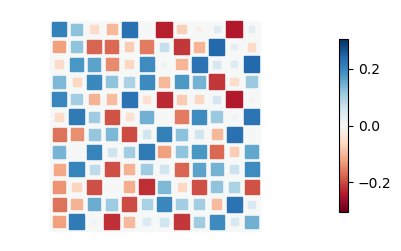

In [24]:
# Look at the Floquet Hamiltonian
fig, ax = plt.subplots(1, figsize=[5,3])
qt.hinton(model.A, ax=ax)

In the next figures, we will compare the (substrobe-measured) DMD eigenmodes to the Floquet eigenmodes and the RWA eigenmodes.

I will use a shortcut to compute the exact Floquet eigenmodes. I will compute DMD for the fully measured system. All I need to show is that the substrobed-DMD modes match the full modes.

We also need to compute the rotating wave approximation eigenmodes and eigenvalues.

Take the adjoint representation of the Hamiltonian in the rotating wave approximation:
\begin{equation}
    \frac{\Omega}{2} \mathbb{1}+\frac{\left(\Delta-\Omega\right)}{2} \sigma_z+\frac{V}{2} \sigma_x
    \mapsto \frac{\left(\Delta-\Omega\right)}{2} L_z + \frac{V}{2} L_x \,.
\end{equation}
so the dynamics are $\dot{\vec{\rho}} = L_H \vec{\rho}$ where
\begin{equation}
    L_H = \frac{1}{2} \left(\begin{array}{ccc}
        0 & -(\Delta - \Omega) & 0 \\
        \Delta - \Omega & 0 & -V \\
        0 & V & 0 \end{array}\right)
\end{equation}

In [ ]:
Lh = np.array([[0, -(Delta - Omega), 0],[Delta-Omega, 0, -c_args['V']], [0, c_args['V'], 0]])
heigs, hmodes = np.linalg.eig(sp.linalg.expm(Lh*T))
hsort = np.argsort(heigs)[::-1]

In [ ]:
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14 

fig, ax = plt.subplots(1,figsize=[4,4])
ax.set_aspect('equal'), ax.set_xlim([-1.2, 1.2]), ax.set_ylim([-1.2, 1.2])

for i in range(3):
    color = cmap(6) if i == 0 else cmap(5)   
    ax.plot(model.eigs[msort].real[i], model.eigs[msort].imag[i], ms=18, marker='x', markeredgewidth=2, ls='', color=color)
    ax.plot(full_model.eigs[fmsort].real[i], full_model.eigs[fmsort].imag[i], ms=20, marker='o', markeredgewidth=3, markerfacecolor='None', ls='', color=color)
    ax.plot(heigs[hsort].real[i], heigs[hsort].imag[i], ms=18, marker='+', markeredgewidth=2, markerfacecolor='None', ls='', color=color)
    
ax.add_artist(plt.Circle((0, 0), 1, color='k', linestyle='--', fill=False))

custom_lines = [mpl.lines.Line2D([0], [0], color='k', ls='', ms=10, markerfacecolor='None', marker='o', markeredgewidth=2),
                mpl.lines.Line2D([0], [0], color='k', ls='', ms=10, marker='x', markeredgewidth=2),
                mpl.lines.Line2D([0], [0], color='k', ls='', ms=10, marker='+', markeredgewidth=2),]
ax.legend(custom_lines, ['Exact', 'DMD', 'RWA'], fontsize=14, ncol=1, loc='center',frameon=False)

In [ ]:
mpl.rcParams['xtick.labelsize'] = 12 
mpl.rcParams['ytick.labelsize'] = 12 
mpl.rcParams["font.family"] = "serif"

figs = []
axes = []
for i in range(3):
    f, a = plt.subplots(2, 3, figsize=[6,3])
    figs.append(f)
    axes.append(a)

full_tsmode = ts[:sim_discretization]
tsmode = ts[::measurement_skip][:mm]
    
for imode, amode in enumerate(hmodes.T):
    Mmode = np.vstack([sp.linalg.expm(Lh*t)@amode for t in full_tsmode]).T
    Mmode = Mmode/Mmode[0,0] 
    for j in range(n_measure):
        axes[imode][0,j].plot(full_tsmode, Mmode[j].real, ls='--', lw=1, alpha=1, color=cmap(j))
        axes[imode][1, j].plot(full_tsmode, Mmode[j].imag, ls='--', lw=1, alpha=1, color=cmap(j))  

for imode, amode in enumerate(model.modes.T):
    norm = amode[0]
    for j in range(n_measure):
        jmode = amode[j::n_measure]
        jmode = jmode/norm
        axes[imode][0, j].plot(tsmode, jmode.real, color=cmap(j), ls='', markeredgewidth=1.5, ms=10, marker='x', markerfacecolor='None')
        axes[imode][1, j].plot(tsmode, jmode.imag, color=cmap(j), ls='', markeredgewidth=1.5, ms=10, marker='x', markerfacecolor='None')
    
for imode, amode in enumerate(full_model.modes.T):
    norm = amode[0]
    for j in range(n_measure):
        jmode = amode[j::n_measure]
        jmode = jmode/norm
        axes[imode][0,j].plot(full_tsmode, jmode.real, lw=1, color=cmap(j))
        axes[imode][1,j].plot(full_tsmode, jmode.imag, lw=1, color=cmap(j))

ytick = [-1.5,0,1.5]
for ia, a in enumerate(axes):
    for i in range(2):
        for j in range(3):
            a[i,j].set_ylim([-2.1, 2.1]) 
            a[i,j].set_xlim([-0.05,.9])
            a[i,j].set_yticks(ytick)
            if j == 0:
                a[i,j].set_yticklabels(ytick)
            else:
                a[i,j].set_yticklabels([])
            if i == 0 or ia == 0:
                a[i,j].set_xticklabels([])
for i, f in enumerate(figs):
    f.tight_layout()
    f.subplots_adjust(wspace=0, hspace=0)

In [ ]:
mpl.rcParams['xtick.labelsize'] = 14 
mpl.rcParams['ytick.labelsize'] = 14 

# Make new prediction beyond training range
ts_test = ts[::sim_discretization][ttsplit:] - ts[ttsplit*sim_discretization] # need to predict from 0
X_predict = model.predict_dst(ts_test, X[:,ttsplit])

ts_predict = ts[::measurement_skip][ttsplit*mm:]
res_predict = fshape(X_predict, mm, True).real

fig, ax = plt.subplots(1,figsize=[10,2.25])
y_lim = [-1.2,1.2]
for m in range(n_measure):
    ax.plot(ts, result.expect[m], color=cmap(m), label=measure_name[m], alpha=.5)
    
    ax.plot(ts[::measurement_skip][ttsplit*mm:], res[m,::measurement_skip][ttsplit*mm:], 
            ls='', ms=10, color=cmap(m), marker='o', markerfacecolor='None', markeredgewidth=1)
    
    ax.plot(ts_predict[mm:], res_predict[m][mm:], color=cmap(m), marker='x', ls='', markeredgewidth=2)
    ax.plot(ts_predict[:mm], res_predict[m][:mm], color=cmap(m), marker='o', ls='', markeredgewidth=2)
    
    
ax.vlines(ts[::sim_discretization], y_lim[0], y_lim[1], ls='--', color='k', alpha=0.33)
ax.vlines(ts_predict[::mm][0], y_lim[0], y_lim[1], ls='-', color='k', alpha=1)

ax.set_ylim(y_lim)
ax.set_xlim([0,11.8])
fig.tight_layout()

# Example 3

This experiment will explore stroboscopic dynamics for the case where we are limited in the measurements we can take. This is like working in the interaction picture with the rotating wave approximation. Indeed, if you only consider the amplitudes of the resonance frequency we are studying a discretized envelope with a discretization length related to the period of the bare oscillation (or, more accurately, the carrier that we have tuned to the bare oscillation). What is more, if we recall what we saw from the Floquet DMD results in Figure 2, the use of the Floquet theory makes these models accurate independent of the RWA.

Based on these ideas, the Floquet theory stuff we talk about here really only makes sense if you're dealing with strong coupling where the RWA breaks down. If you are not, you can take the RWA and work in an interaction frame with envelopes like we talked about in the variation on Example 1.

Also, as an aside, if you are in the interaction picture then the amplitudes attached to the resonance frequency are like the value of the constant time step on the envelope. However, this framework lets you worry about other frequencies.

## Construct a model from Fourier coefficients

In [ ]:
# Hamiltonian
w0 = 1
V0 = 1
Delta = 2*np.pi*w0
H0 = Delta/2*qt.sigmaz()
H1 = V0*1/2*qt.sigmax()

# Measurements
measure_list = [qt.sigmax(), qt.sigmay(), qt.sigmaz()] 
measure_name = ['<{}>'.format(s) for s in ['x','y','z']]
n_measure = len(measure_list)
y_lim = [-1.5,1.5]

# Fourier/Floquet parameters
Omega = Delta # -- decide how often you want to measure
T = (2*np.pi/Omega)
n_fourier = 7 

# Time parameters
n_discretization = 16
n_periods = 8
n_strobes = 2

# Count of indicies between various lengths of time
i_total = n_periods*n_discretization*n_fourier
i_period = n_fourier*n_discretization
i_strobe = i_period//n_strobes

# Time series for simulation
ts = np.linspace(0, n_periods*T, i_total, endpoint=True)
dt_fourier = ts[n_discretization] - ts[0]

# Generate monotone control signals
control_list = []
repetition = 1
ampl_list = np.linspace(-1,1,41)[::-1].tolist()
for ampl in ampl_list*repetition:
    for u_hat in hf.dft_coef_span(n_fourier):
        control_list.append({'u_hat': ampl*u_hat, 'dt': dt_fourier})
n_experiments = len(control_list)

In [ ]:
# Run multi-thread experiments
def run_wrapper(arg):
    import importlib
    import numpy as np
    import qutip as qt
    hf = importlib.import_module('helper_functions')
    # Hamiltonian
    w0 = 1
    V0 = 1
    Delta = 2*np.pi*w0
    H0 = Delta/2*qt.sigmaz()
    H1 = V0*1/2*qt.sigmax()

    # Measurements
    measure_list = [qt.sigmax(), qt.sigmay(), qt.sigmaz()] 
    measure_name = ['<{}>'.format(s) for s in ['x','y','z']]
    n_measure = len(measure_list)
    y_lim = [-1.5,1.5]

    # Fourier/Floquet parameters
    Omega = Delta # -- decide how often you want to measure
    T = (2*np.pi/Omega)
    n_fourier = 7 

    # Time parameters
    n_discretization = 16
    n_periods = 8
    n_strobes = 2

    # Count of indicies between various lengths of time
    i_total = n_periods*n_discretization*n_fourier
    i_period = n_fourier*n_discretization
    i_strobe = i_period//n_strobes

    # Time series for simulation
    ts = np.linspace(0, n_periods*T, i_total, endpoint=True)
    dt_fourier = ts[n_discretization] - ts[0]

    # Generate monotone control signals
    control_list = []
    repetition = 1
    ampl_list = np.linspace(-1,1,41)[::-1].tolist()
    for ampl in ampl_list*repetition:
        for u_hat in hf.dft_coef_span(n_fourier):
            control_list.append({'u_hat': ampl*u_hat, 'dt': dt_fourier})
    n_experiments = len(control_list)
    class QubitExperiment:
        ''' A container for data saved during a set of experiments. '''
        def __init__(self):
            self.X = []
            self.Y = []
            self.Uy = []
            self.Ty = []
            self.Args_List = []
            self._finalized = False
        
        def save(self, iX, iY, iUy, iTy, iArgs):
            if self._finalized:
                raise ValueError('Cannot save data. QubitExperiment has been finalized.')
            
            self.X.append(iX)
            self.Y.append(iY)
            self.Uy.append(iUy)
            self.Ty.append(iTy)
            self.Args_List.append(iArgs)
        
        def dump(self):
            if self._finalized:
              raise ValueError('Cannot dump data. QubitExperiment has been finalized.')
        
            for i in range(len(self.X)):
                yield self.X[i], self.Y[i], self.Uy[i], self.Ty[i], self.Args_List[i]

        def finalize(self):
            self._finalized = True
            self.X_flat = np.hstack(self.X)
            self.Y1_flat = np.hstack([y[:, :-1] for y in self.Y])
            self.Y2_flat = np.hstack([y[:, 1:] for y in self.Y])
            self.U1y_flat = np.hstack([u[:, :-1] for u in self.Uy])
            self.T1y_flat = np.hstack([t[:-1] for t in self.Ty])


    def join_qubit_experiments(qbExpermList):
        
        joinedQbExperm = QubitExperiment()
        for aQbExperm in qbExpermList:
            for data in aQbExperm.dump():
                joinedQbExperm.save(*data)
        joinedQbExperm.finalize()
        return joinedQbExperm
    # Library order
    order = 3
    def run_experiment(args, order):
        # Make a data containers
        QbData = QubitExperiment()
    
        # Resample the control
        resampled_args = hf.resample_u_dft(args, n_discretization)
        control = hf.u_idft(ts, resampled_args)
    
        # Run the experiment
        psi0 = qt.basis(2,1)
        H = [H0, [H1, control]]
        result = qt.mesolve(H, psi0, ts, [], measure_list)
        X = np.array(result.expect)
            
        # Collect strobe data
        Y = fshape(X[:,::i_strobe],  n_strobes)
        Ty = ts[::i_period]

        # We only have monotone controls so we just repeat the pulse
        control_library = [hf.make_control_library(args['u_hat'], order)]*n_periods
        Uy = np.hstack(control_library)
    
        # Save data
        QbData.save(X, Y, Uy, Ty, resampled_args)
        return QbData
    def fshape(data, n_measure, invert=False):
       if invert:
            return data.T.reshape(n_measure*data.shape[1], -1).T
       else:
            return data.T.reshape(-1, n_measure*data.shape[0]).T
    return run_experiment(arg, order=order)
# protect the entry point
if __name__ == '__main__':
    # add freeze support for multiprocessing
    mp.freeze_support()
    with pool.Pool(2) as p:
        r = list(p.imap(run_wrapper, control_list))
    QbData = join_qubit_experiments(r)



In [ ]:
# Fit model
model = dmd.biDMD(QbData.Y2_flat, QbData.Y1_flat, QbData.U1y_flat, QbData.T1y_flat, threshold_type='percent', threshold=1e-5)
fig, ax = dmd.plot_eigs(model.eigs, figsize=[3,3])
ax.set_xlim([-1.1,1.5])
model.eigs

These eigenvalues only tell part of the story because there's a lot of dynamics in the control operator. But we can get some sense of a bare oscillation from this, maybe.

    
Let's look at how our model handles reproducing the training data. Try going into the training and increasing the order of the multinomial powers if you do not see a good enough fit in  $$\texttt{run_experiment(arg, order)}$$ . Also, try lowering the order to see the fit break down.

In [ ]:
# Plot only one ampltiude set of the training pulses
plot_ampl = 0
plot_reps = len(ampl_list)*repetition
for i in range(plot_ampl*n_experiments//plot_reps, (plot_ampl+1)*n_experiments//plot_reps):
    fig,axes = plt.subplots(1,2, figsize=[12,3])
    ax=axes[0]
    Y_prediction = model.predict_dst(control=QbData.Uy[i], x0=QbData.Y[i][:,0])
    prediction = fshape(Y_prediction, n_strobes, True)
    for m in range(3):
        ax.plot(ts, QbData.X[i][m], color=cmap2(2*m+1))
    for m in range(3):
        ax.plot(ts[::i_strobe], QbData.X[i][m,::i_strobe], ls='', marker='o', markeredgewidth=2, markerfacecolor='None', markeredgecolor=cmap2(2*m), markersize=10)
        ax.plot(ts[::i_strobe], prediction[m], ls='', markeredgewidth=1, marker='x', color=cmap2(2*m), markersize=8)
    ax.set_ylim([-1.2,1.2])
    
    ax=axes[1]
    control = hf.u_idft(ts[:i_period], QbData.Args_List[i])
    ax.plot(ts[:i_period], control)
    ax.set_ylim([-1.5,1.5])

At this point I want to comment that the data-drive approach means that when you measure something like $\sigma_x$ with a fast oscillation in the lab frame, you do not need to be exactly correct. That is, if you are slightly rotated off the correct value by a fixed phase when you apply the pulse to generate the $\sigma_x$ measurement, if you are off by the same phase, the data-drive model will account for this.

Said another way, we don't actually need to measure the Bloch vector. We only need to measure a set of linearly independent observables sufficient to reconstruct the dynamics.

## Apply the model to new controls

In [ ]:
# In this version you supply a list of control arguments, one for each Floquet period.
# You might need a control function for the true signal if it's outside the Fourier span.
# We'll also mess with the initial condition.
def run_experiment_v2(args_list, order, control_fn=None):
    # Make data container
    QbData = QubitExperiment()
    
    control = []
    control_library = []
    saved_args = []
    for i, args in enumerate(args_list):
        # Get the appropriate time window
        ts_window = ts[i*i_period:(i+1)*i_period]
        # Resample the control
        saved_args.append(hf.resample_u_dft(args, n_discretization))
        # Store the control and control library
        if control_fn:
            control.append(control_fn(ts_window))
        else:
            control.append(hf.u_idft(ts_window, saved_args[-1]))
        control_library.append(hf.make_control_library(args['u_hat'], order))
    control = np.hstack(control)
    Uy = np.hstack(control_library)
    
    # Run the experiment
    psi0 = qt.basis(2,1)
    psi0 = psi0/psi0.norm()
    H = [H0, [H1, control]]
    result = qt.mesolve(H, psi0, ts, [], measure_list)
    X = np.array(result.expect)
            
    # Collect strobe data
    Y = fshape(X[:,::i_strobe],  n_strobes)
    Ty = ts[::i_period]
    
    # Save data
    QbData.save(X, Y, Uy, Ty, saved_args)
    
    return QbData

Now we run a three test examples. One at resonance, one random but in the training span, and one outside the training span.

In [ ]:
order = 3  # Set the multinomial power order for the control library

n_tests = 3
QbList_Test = []
ts_fourier = ts[:i_period][::n_discretization]

# 1. Resonance
u_hat = np.fft.fft(np.cos(Delta*ts_fourier), n_fourier)
QbList_Test.append(run_experiment_v2([{'u_hat': u_hat, 'dt': dt_fourier}]*n_periods, order, lambda t: np.cos(Delta*t)))

# 2. Random control -- Generate a random pulse with all the Frequency content with only positive Fourier coefficients (so something happens)
test_list = [{'u_hat': 1.5*hf.dft_coef_rand(n_fourier, 3, True), 'dt': dt_fourier} for i in range(n_periods)]
QbList_Test.append(run_experiment_v2(test_list, order))

# 3. Sawtooth wave at resonance
u_hat = np.fft.fft(sp.signal.sawtooth(Delta*ts_fourier), n_fourier)
QbList_Test.append(run_experiment_v2([{'u_hat': u_hat, 'dt': dt_fourier}]*n_periods, order, lambda t: sp.signal.sawtooth(Delta*t)))

# Plot the experiments
QbTest = join_qubit_experiments(QbList_Test)
for i in range(n_tests):
    fig,axes = plt.subplots(1,2, figsize=[12,3])
    ax=axes[0]
    Y_prediction = model.predict_dst(control=QbTest.Uy[i], x0=QbTest.Y[i][:,0])
    prediction = fshape(Y_prediction, n_strobes, True)
    for m in range(3):
        ax.plot(ts, QbTest.X[i][m], color=cmap2(2*m+1))
    for m in range(3):
        ax.plot(ts[::i_strobe], QbTest.X[i][m,::i_strobe], ls='', marker='o', markeredgewidth=2, markerfacecolor='None', markeredgecolor=cmap2(2*m), markersize=10)
        ax.plot(ts[::i_strobe], prediction[m], ls='', markeredgewidth=1, marker='x', color=cmap2(2*m), markersize=8)
        ax.set_ylim([-1.4,1.4])

    ax=axes[1]
    for window, args in enumerate(QbTest.Args_List[i]):
        ts_window = ts[window*i_period:(window+1)*i_period]
        ax.plot(ts_window, hf.u_idft(ts_window, args), color='k')
        ax.set_ylim([-1.4,1.4])